In [7]:
# does a worse model give a bigger gap?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score,roc_curve

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from scipy.special import factorial
import time 


import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
# prompt: give me an autoregressive generative model based on transformers that predicts the next term in a sequence of integers, written in pytorch

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class IntegerSequencePredictor(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(IntegerSequencePredictor, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.embedding(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


#model = IntegerSequencePredictor(ntoken, ninp, nhead, nhid, nlayers)



In [3]:
# Example Usage:
# Assume you have a vocabulary size `ntoken` (the maximum possible integer value + 1)
# and a sequence of integer tokens `src`.
nbins=250
# the data will be binned from 1 to nbins
# nbins+1 will be the start token
ntoken = nbins+2 # Example: integers from 0 to 99
# ntoken includes 0 so we need nbins+2 tokens
ninp = 64 # Embedding dimension
nhead = 2 # Number of attention heads
nhid = 64 # Dimension of the feedforward network model
nlayers = 2 # Number of transformer encoder layers


In [4]:
def add_start_token(data):
    # data shape: (nevents,seq_length)
    # want to add ntoken-1 to each sequence
    return np.hstack(((ntoken-1)*np.ones(len(data)).astype('int').reshape((-1,1)),data))

def preprocess_raw_to_binned(data_raw):
    binneddata=np.digitize(data_raw,bins)
    data_x=bins[binneddata-1]+delta/2
    binneddata_sorted=binneddata[np.arange(len(binneddata)).reshape((-1,1)),np.argsort(np.floor(np.abs(data_x)/delta),axis=-1)[:,::-1]]
    binneddata_sorted=add_start_token(binneddata_sorted)
    return binneddata_sorted

In [5]:
bins=np.linspace(0,10,nbins+1)
delta=bins[1]-bins[0]
print(delta)

0.04


In [6]:
bins

array([ 0.  ,  0.04,  0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,
        0.36,  0.4 ,  0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,
        0.72,  0.76,  0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ,  1.04,
        1.08,  1.12,  1.16,  1.2 ,  1.24,  1.28,  1.32,  1.36,  1.4 ,
        1.44,  1.48,  1.52,  1.56,  1.6 ,  1.64,  1.68,  1.72,  1.76,
        1.8 ,  1.84,  1.88,  1.92,  1.96,  2.  ,  2.04,  2.08,  2.12,
        2.16,  2.2 ,  2.24,  2.28,  2.32,  2.36,  2.4 ,  2.44,  2.48,
        2.52,  2.56,  2.6 ,  2.64,  2.68,  2.72,  2.76,  2.8 ,  2.84,
        2.88,  2.92,  2.96,  3.  ,  3.04,  3.08,  3.12,  3.16,  3.2 ,
        3.24,  3.28,  3.32,  3.36,  3.4 ,  3.44,  3.48,  3.52,  3.56,
        3.6 ,  3.64,  3.68,  3.72,  3.76,  3.8 ,  3.84,  3.88,  3.92,
        3.96,  4.  ,  4.04,  4.08,  4.12,  4.16,  4.2 ,  4.24,  4.28,
        4.32,  4.36,  4.4 ,  4.44,  4.48,  4.52,  4.56,  4.6 ,  4.64,
        4.68,  4.72,  4.76,  4.8 ,  4.84,  4.88,  4.92,  4.96,  5.  ,
        5.04,  5.08,

In [8]:
ndim=10

sigdata_raw=np.abs(np.random.normal(size=(150000,ndim)))
bgdata_raw=np.abs(np.random.normal(size=(150000,ndim)))
alldata_raw=np.concatenate((sigdata_raw,bgdata_raw))
alllabels=np.concatenate((np.ones(len(sigdata_raw)),np.zeros(len(bgdata_raw))))

binneddata_sorted=preprocess_raw_to_binned(alldata_raw)

perm0=np.random.permutation(len(binneddata_sorted))

In [9]:
np.max(binneddata_sorted[:,1:])

141

In [10]:
traindata=binneddata_sorted[perm0[:200000]]
trainlabels=alllabels[perm0[:200000]]

testdata=binneddata_sorted[perm0[200000:]]
testlabels=alllabels[perm0[200000:]]

traindata_raw=alldata_raw[perm0[:200000]]
testdata_raw=alldata_raw[perm0[200000:]]

In [11]:
traindata[trainlabels==1].shape

(99860, 11)

In [12]:
x=traindata[trainlabels==1]
X_train = torch.tensor(x, dtype=torch.long)

x=testdata[testlabels==1]
X_test = torch.tensor(x, dtype=torch.long)

train_dataset = TensorDataset(X_train)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model_sig = IntegerSequencePredictor(ntoken, ninp, nhead, nhid, nlayers)
model_sig.to(device)

# 3. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sig.parameters(), lr=0.001)

# 4. Train the model
epochs = 50
losslist=[]
bestloss=99999
torch.save(model_sig.state_dict(),"model_sig_init.pt")

for epoch in range(epochs):
    model_sig.train()
    for inputs in train_loader:
        optimizer.zero_grad()
        # Forward pass
        inputs2=torch.transpose(inputs[0],0,1)
        src_mask = model_sig.generate_square_subsequent_mask(inputs2.size(0))


        
        outputs = model_sig(inputs2.to(device),src_mask.to(device))
#        print(outputs.shape)
#        print(inputs2.shape)
        loss = criterion(outputs[:-1].reshape(-1, ntoken),inputs2[1:].reshape(-1).to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()

    model_sig.eval()
    with torch.no_grad():
        loss=0
        nbatch=0
        for inputs in test_loader:
            inputs2=torch.transpose(inputs[0],0,1)
            src_mask = model_sig.generate_square_subsequent_mask(inputs2.size(0))

            outputs = model_sig(inputs2.to(device),src_mask.to(device))
            loss+=criterion(outputs[:-1].reshape(-1, ntoken),inputs2[1:].reshape(-1).to(device))
            nbatch+=1
        loss=loss/nbatch
        losslist.append(loss.detach().cpu().numpy())
        
        print('Epoch, Loss of the model on the test data: ',epoch,loss)
        torch.save(model_sig.state_dict(),"model_sig_ep_"+str(epoch)+".pt")
        if loss<bestloss:
            bestloss=loss
            print('best loss ',bestloss)
            torch.save(model_sig.state_dict(),"model_sig_best.pt")

/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch, Loss of the model on the test data:  0 tensor(2.5574, device='cuda:0')
best loss  tensor(2.5574, device='cuda:0')
Epoch, Loss of the model on the test data:  1 tensor(2.5397, device='cuda:0')
best loss  tensor(2.5397, device='cuda:0')
Epoch, Loss of the model on the test data:  2 tensor(2.5342, device='cuda:0')
best loss  tensor(2.5342, device='cuda:0')
Epoch, Loss of the model on the test data:  3 tensor(2.5337, device='cuda:0')
best loss  tensor(2.5337, device='cuda:0')
Epoch, Loss of the model on the test data:  4 tensor(2.5298, device='cuda:0')
best loss  tensor(2.5298, device='cuda:0')
Epoch, Loss of the model on the test data:  5 tensor(2.5247, device='cuda:0')
best loss  tensor(2.5247, device='cuda:0')
Epoch, Loss of the model on the test data:  6 tensor(2.5271, device='cuda:0')
Epoch, Loss of the model on the test data:  7 tensor(2.5221, device='cuda:0')
best loss  tensor(2.5221, device='cuda:0')
Epoch, Loss of the model on the test data:  8 tensor(2.5218, device='cuda:0

In [13]:

#x=traindata[trainlabels==0]
#X_train = torch.tensor(x, dtype=torch.long)
#
#x=testdata[testlabels==0]
#X_test = torch.tensor(x, dtype=torch.long)


# Let's try something diabolical: train another GPT model on the SAME data -- is there still a gap?

x=traindata[trainlabels==1]
X_train = torch.tensor(x, dtype=torch.long)

x=testdata[testlabels==1]
X_test = torch.tensor(x, dtype=torch.long)

train_dataset = TensorDataset(X_train)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


model_bg = IntegerSequencePredictor(ntoken, ninp, nhead, nhid, nlayers)
model_bg.to(device)


# 3. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bg.parameters(), lr=0.001)

# 4. Train the model
epochs = 50
losslist=[]
bestloss=999999
torch.save(model_bg.state_dict(),"model_bg_init.pt")


for epoch in range(epochs):
    model_bg.train()
    for inputs in train_loader:
        optimizer.zero_grad()
        # Forward pass
        inputs2=torch.transpose(inputs[0],0,1)
        src_mask = model_bg.generate_square_subsequent_mask(inputs2.size(0))

        outputs = model_bg(inputs2.to(device),src_mask.to(device))
        loss = criterion(outputs[:-1].reshape(-1, ntoken),inputs2[1:].reshape(-1).to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()

    model_bg.eval()
    with torch.no_grad():
        loss=0
        nbatch=0
        for inputs in test_loader:
            inputs2=torch.transpose(inputs[0],0,1)
            src_mask = model_bg.generate_square_subsequent_mask(inputs2.size(0))

            outputs = model_bg(inputs2.to(device),src_mask.to(device))
            loss+=criterion(outputs[:-1].reshape(-1, ntoken),inputs2[1:].reshape(-1).to(device))
            nbatch+=1
        loss=loss/nbatch
        losslist.append(loss.detach().cpu().numpy())
        
        print('Epoch, Loss of the model on the test data: ',epoch,loss)
        torch.save(model_bg.state_dict(),"model_bg_ep_"+str(epoch)+".pt")
        if loss<bestloss:
            bestloss=loss
            print('best loss ',bestloss)
            torch.save(model_bg.state_dict(),"model_bg_best.pt")

/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch, Loss of the model on the test data:  0 tensor(2.5542, device='cuda:0')
best loss  tensor(2.5542, device='cuda:0')
Epoch, Loss of the model on the test data:  1 tensor(2.5397, device='cuda:0')
best loss  tensor(2.5397, device='cuda:0')
Epoch, Loss of the model on the test data:  2 tensor(2.5348, device='cuda:0')
best loss  tensor(2.5348, device='cuda:0')
Epoch, Loss of the model on the test data:  3 tensor(2.5327, device='cuda:0')
best loss  tensor(2.5327, device='cuda:0')
Epoch, Loss of the model on the test data:  4 tensor(2.5322, device='cuda:0')
best loss  tensor(2.5322, device='cuda:0')
Epoch, Loss of the model on the test data:  5 tensor(2.5269, device='cuda:0')
best loss  tensor(2.5269, device='cuda:0')
Epoch, Loss of the model on the test data:  6 tensor(2.5253, device='cuda:0')
best loss  tensor(2.5253, device='cuda:0')
Epoch, Loss of the model on the test data:  7 tensor(2.5245, device='cuda:0')
best loss  tensor(2.5245, device='cuda:0')
Epoch, Loss of the model on the 

In [1]:
# pip install transformers

from transformers import GPT2Config, GPT2LMHeadModel
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x=traindata[trainlabels==1]
X_train = torch.tensor(x, dtype=torch.long)

x=testdata[testlabels==1]
X_test = torch.tensor(x, dtype=torch.long)

train_dataset = TensorDataset(X_train)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Hugging Face stuff:

config = GPT2Config(
        vocab_size=ntoken,
        n_positions=ndim + 1,   # num_constituents + start token
        n_ctx=ndim + 1,         # num_constituents + start token
        n_embd=ninp,
        n_layer=nlayers,
        n_head=nhead,
        n_inner=nhid,  
        resid_pdrop=0.1,
        embd_pdrop=0.1,
        attn_pdrop=0.1,
        bos_token_id=ntoken - 1,    # start token id
    )

model_sig = GPT2LMHeadModel(config).to(device)

# loss etc

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_sig.parameters(), lr=0.001)

epochs = 50
losslist = []
bestloss = float('inf')

# train:

for epoch in range(epochs):
    model_sig.train()
    for inputs in train_loader:
        optimizer.zero_grad()
        x = inputs[0].to(device)  # (B, L)

        outputs = model_sig(x, labels=x)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Eval
    model_sig.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in test_loader:
            x = inputs[0].to(device)
            outputs = model_sig(x, labels=x)
            val_loss += outputs.loss.item()

    val_loss /= len(test_loader)
    losslist.append(val_loss)
    print(f"Epoch {epoch}, Val Loss: {val_loss:.4f}")

    torch.save(model_sig.state_dict(), f"gpt2_model_sig_ep_{epoch}.pt")
    if val_loss < bestloss:
        bestloss = val_loss
        print("  New best!")
        torch.save(model_sig.state_dict(), "gpt2_model_sig_best.pt")


NameError: name 'torch' is not defined

In [ ]:
model.logits

In [359]:
[1,1,1]==None

False

In [14]:
def batched_bincount(x, dim, max_value):
    target = torch.zeros(x.shape[0], max_value, dtype=x.dtype, device=x.device)
    values = torch.ones_like(x)
    target.scatter_add_(dim, x, values)
    return target
    
def getprob(data,model,normed=False,npermlist=[]):

    bins_t=torch.tensor(bins)

    x = torch.tensor(data, dtype=torch.long)
    dataset = TensorDataset(x)
    dataloader = DataLoader(dataset, batch_size=2048, shuffle=False,num_workers=4)    

    model.eval()
    problist=[]
    if len(npermlist)==0:
        npermlistuse=[]
    else:
        npermlistuse=npermlist
        
    with torch.no_grad():
        for inputs in dataloader:
            inputs=inputs[0]
            if normed and len(npermlist)==0: # compute the fully normalized permutation invariant probability density
                inputs_x=bins_t[(inputs)[:,1:]-1]+delta/2
                counts=batched_bincount(torch.bucketize(torch.abs(inputs_x),bins_t,right=True),1,len(bins_t)+2)
                npermlistuse+=np.prod(factorial(counts.numpy()),axis=-1).tolist()

            inputs=inputs.to(device)
            inputs2=torch.transpose(inputs,0,1)
            src_mask = model.generate_square_subsequent_mask(inputs2.size(0))

            outputs = model(inputs2,src_mask)
            outputs=torch.transpose(outputs,0,1)
            outputs=nn.Softmax(dim=-1)(outputs)
            target_probabilities = torch.gather(outputs[:,:-1,:], -1, inputs[:,1:].unsqueeze(-1)).squeeze(-1)
            target_probabilities=torch.prod(target_probabilities,dim=-1)
#            outputs=outputs.cpu().numpy()
#            inputs=inputs.cpu().numpy()
#
#            print(outputs.shape)
#            
#            for prob,event in zip(outputs,inputs):
#                problist.append(np.prod(prob[:-1][np.arange(ndim),event[1:]]))
            problist+=target_probabilities.cpu().numpy().tolist()
            
    problist=np.array(problist)
    npermlistuse=np.array(npermlistuse)
    if normed:
        problist=npermlistuse*problist/(((20/nbins)**ndim)*factorial(ndim))
    
    return problist

def getprob_fromraw(data_raw,model,normed=False,npermlist=[]):

    data_binned=preprocess_raw_to_binned(data_raw)

    problist=getprob(data_binned,model,normed=normed,npermlist=npermlist)
    
    return problist



In [15]:
# prompt: now give me code that can generate a sequence autoregressively from the trained model

def generate_sequence_autoregressively(model, start_sequence, max_length, temperature=1.0):
    """
    Generates a sequence of integers autoregressively from a trained model.

    Args:
        model (nn.Module): The trained IntegerSequencePredictor model.
        start_sequence (list or torch.Tensor): A list or tensor of initial integers
                                              to start the generation.
                                              Should be 1D.
        max_length (int): The maximum length of the generated sequence.
        temperature (float): Controls the randomness of predictions. Higher values
                             increase randomness. Defaults to 1.0.

    Returns:
        list: The generated sequence of integers, including the start sequence.
    """
    model.eval() # Turn on evaluation mode
    device = next(model.parameters()).device # Get the model's device

    if not isinstance(start_sequence, torch.Tensor):
        input_sequence = torch.tensor(start_sequence, dtype=torch.long).unsqueeze(1).to(device)
    else:
        input_sequence = start_sequence.clone().detach().unsqueeze(1).to(device) # Ensure 2D (seq_len, 1)

    generated_sequence = start_sequence if isinstance(start_sequence, list) else start_sequence.tolist()

    with torch.no_grad():
        for _ in range(max_length - len(generated_sequence)):
            # Generate the source mask for the current input sequence length
            src_mask = model.generate_square_subsequent_mask(input_sequence.size(0)).to(device)

            # Get the model's prediction for the next token
            # The output is (seq_len, batch_size, ntoken)
            output = model(input_sequence, src_mask)

            # Get the logits for the last token in the sequence
            # The last row corresponds to the prediction after seeing the entire input_sequence
            last_token_logits = output[-1, 0, :] # (ntoken,)

            # Apply temperature to logits
            if temperature == 0:
                # Deterministic argmax
                next_token = torch.argmax(last_token_logits).item()
            else:
                # Sample from a categorical distribution
                probabilities = torch.softmax(last_token_logits / temperature, dim=-1)
                next_token = torch.multinomial(probabilities, num_samples=1).item()

            # Append the predicted token to the input sequence for the next step
            next_token_tensor = torch.tensor([[next_token]], dtype=torch.long).to(device)
            input_sequence = torch.cat((input_sequence, next_token_tensor), dim=0)

            # Append the predicted token to the generated sequence list
            generated_sequence.append(next_token)

            # Stop if the generated sequence reaches max_length (already checked by the loop)
            # or if you have a special end-of-sequence token (not implemented here)

    return generated_sequence

def generate_batch_sequences_autoregressively(model, start_sequences, max_length, temperature=1.0):
    """
    Generates a batch of sequences autoregressively from a trained model.

    Args:
        model (nn.Module): The trained IntegerSequencePredictor model.
        start_sequences (list of list or torch.Tensor): A list of lists or a tensor
                                                         where each inner list/row is
                                                         an initial sequence to start
                                                         generation for one sample in the batch.
                                                         Shape should be (batch_size, initial_seq_len).
        max_length (int): The maximum length of the generated sequences.
        temperature (float): Controls the randomness of predictions. Higher values
                             increase randomness. Defaults to 1.0.

    Returns:
        list of list: A list where each inner list is a generated sequence
                      (including the start sequence).
    """
    model.eval() # Turn on evaluation mode
    device = next(model.parameters()).device # Get the model's device

    if not isinstance(start_sequences, torch.Tensor):
        # Assuming start_sequences is a list of lists
        # Transpose to get shape (initial_seq_len, batch_size) for model input
        max_initial_len = max(len(seq) for seq in start_sequences)
        # Pad shorter sequences if they have different initial lengths
        padded_start_sequences = [seq + [0] * (max_initial_len - len(seq)) for seq in start_sequences] # Pad with 0s
        input_sequence = torch.tensor(padded_start_sequences, dtype=torch.long).transpose(0, 1).to(device)
    else:
        # Assuming start_sequences is a tensor of shape (batch_size, initial_seq_len)
        # Transpose to get shape (initial_seq_len, batch_size) for model input
        input_sequence = start_sequences.clone().detach().transpose(0, 1).to(device)

    batch_size = input_sequence.size(1)
    initial_seq_len = input_sequence.size(0)

    # Initialize the list of generated sequences for the batch
    # Each element will be a list representing one sequence
    generated_sequences = [seq.tolist() for seq in input_sequence.transpose(0, 1)]

    with torch.no_grad():
        # Generate token by token for the entire batch
        for _ in range(max_length - initial_seq_len):
            # Generate the source mask for the current input sequence length
            # Mask needs to be (seq_len, seq_len)
            src_mask = model.generate_square_subsequent_mask(input_sequence.size(0)).to(device)

            # Get the model's prediction for the next token
            # The output is (seq_len, batch_size, ntoken)
            output = model(input_sequence, src_mask)

            # Get the logits for the last token across the entire batch
            # The last row corresponds to the prediction after seeing the entire input_sequence
            last_token_logits = output[-1, :, :] # Shape: (batch_size, ntoken)

            # Apply temperature to logits and sample for each sequence in the batch
            if temperature == 0:
                # Deterministic argmax for each sequence in the batch
                next_tokens = torch.argmax(last_token_logits, dim=-1) # Shape: (batch_size,)
            else:
                # Sample from a categorical distribution for each sequence in the batch
                probabilities = torch.softmax(last_token_logits / temperature, dim=-1) # Shape: (batch_size, ntoken)
                # Multinomial sampling returns a tensor of shape (batch_size, num_samples)
                # We need 1 sample per sequence, so result is (batch_size, 1)
                next_tokens = torch.multinomial(probabilities, num_samples=1).squeeze(-1) # Shape: (batch_size,)

            # Append the predicted tokens to the input sequence for the next step
            # Need to reshape next_tokens to (1, batch_size) for concatenation
            next_tokens_tensor = next_tokens.unsqueeze(0).to(device) # Shape: (1, batch_size)
            input_sequence = torch.cat((input_sequence, next_tokens_tensor), dim=0) # Shape: (current_seq_len + 1, batch_size)

            # Append the predicted tokens to the generated sequence list for each sequence
            for i in range(batch_size):
                generated_sequences[i].append(next_tokens[i].item())


    return generated_sequences


In [16]:
gendata_bg=[]
batch_size=128

for ii in range(1000):
    if ii%100==0:
        print(ii)
    gendata_bg.append(generate_batch_sequences_autoregressively(model_bg, \
                                    (np.ones(batch_size)*(ntoken-1)).reshape((-1,1)).astype('int').tolist(), ndim+1, temperature=1))
gendata_bg=np.array(gendata_bg).reshape((-1,ndim+1))

gendata_sig=[]
batch_size=128

for ii in range(1000):
    if ii%100==0:
        print(ii)
    gendata_sig.append(generate_batch_sequences_autoregressively(model_sig, \
                                    (np.ones(batch_size)*(ntoken-1)).reshape((-1,1)).astype('int').tolist(), ndim+1, temperature=1))
gendata_sig=np.array(gendata_sig).reshape((-1,ndim+1))


0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [17]:
gendata_sig_x=bins[np.clip(gendata_sig[:,1:],a_min=None,a_max=499)-1]+delta/2
gendata_bg_x=bins[np.clip(gendata_bg[:,1:],a_min=None,a_max=499)-1]+delta/2


In [18]:
gendata_sig_x.shape

(128000, 10)

In [19]:
testdata_x=bins[testdata[testlabels==1][:,1:]-1]+delta/2
print(testdata_x.shape)

(49969, 10)


In [20]:
moredata=np.random.normal(size=(1000000,ndim))

moredata_sorted=moredata[np.arange(len(moredata)).reshape((-1,1)),np.argsort(np.abs(moredata),axis=-1)[:,::-1]]


In [21]:
moredata_sorted.shape

(1000000, 10)

Text(0.5, 0, 'all x')

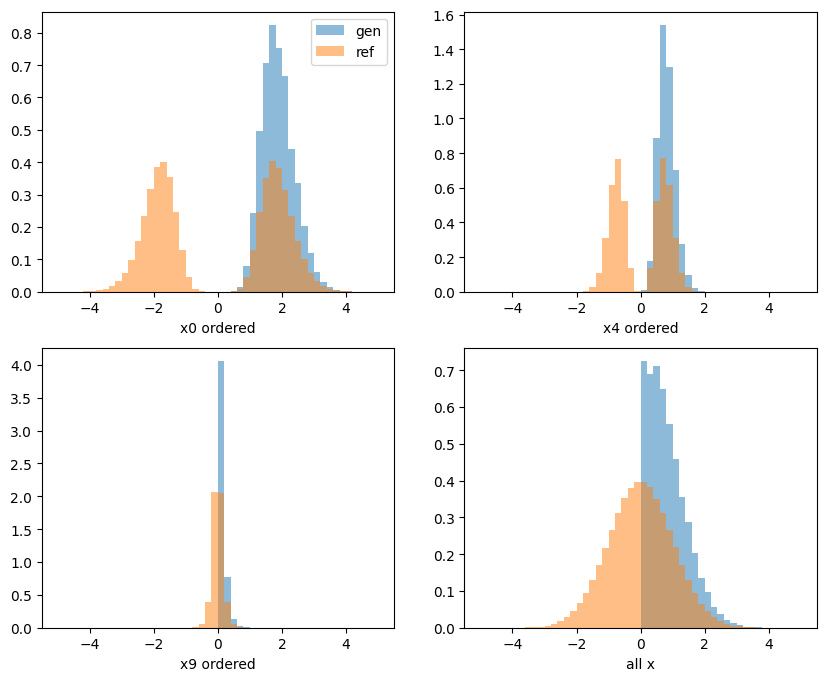

In [22]:
fig,ax=plt.subplots(2,2,figsize=(10,8))

_=ax[0,0].hist(gendata_bg_x[:,0],bins=50,density=True,range=[-5,5],alpha=0.5,label='gen')
_=ax[0,0].hist(moredata_sorted[:,0],bins=50,density=True,range=[-5,5],alpha=0.5,label='ref')
ax[0,0].set_xlabel('x0 ordered')
ax[0,0].legend()

_=ax[0,1].hist(gendata_bg_x[:,4],bins=50,density=True,range=[-5,5],alpha=0.5,label='gen')
_=ax[0,1].hist(moredata_sorted[:,4],bins=50,density=True,range=[-5,5],alpha=0.5,label='ref')
ax[0,1].set_xlabel('x4 ordered')

_=ax[1,0].hist(gendata_bg_x[:,9],bins=50,density=True,range=[-5,5],alpha=0.5,label='gen')
_=ax[1,0].hist(moredata_sorted[:,9],bins=50,density=True,range=[-5,5],alpha=0.5,label='ref')
ax[1,0].set_xlabel('x9 ordered')

_=ax[1,1].hist(gendata_bg_x.reshape((-1)),bins=50,density=True,range=[-5,5],alpha=0.5,label='gen')
_=ax[1,1].hist(moredata_sorted.reshape((-1)),bins=50,density=True,range=[-5,5],alpha=0.5,label='ref')
ax[1,1].set_xlabel('all x')



In [23]:
prob_gensample_genmodel=getprob(gendata_bg,model_bg,normed=True)
prob_refsample_genmodel=getprob_fromraw(moredata,model_bg,normed=True)
prob_genmodel=np.concatenate((prob_gensample_genmodel,prob_refsample_genmodel))
logp_genmodel=np.log(prob_genmodel)

logp_refmodel=-np.sum(np.concatenate((gendata_bg_x,moredata))**2,axis=-1)/2

labels=np.concatenate((np.ones(len(gendata_bg)),np.zeros(len(moredata))))


/tmp/ipykernel_4080897/3288860565.py:4: RuntimeWarning: divide by zero encountered in log
  logp_genmodel=np.log(prob_genmodel)


In [24]:
auc=roc_auc_score(labels,logp_genmodel-logp_refmodel)
fpr,tpr,_=roc_curve(labels,logp_genmodel-logp_refmodel)

plt.plot(fpr,tpr)
plt.title(auc)
plt.xlabel('fpr')
plt.ylabel('tpr')

ValueError: Input contains infinity or a value too large for dtype('float64').

In [244]:
testdata_x_shuffled=[]
for ev in testdata_x:
    perm=np.random.permutation(len(ev))
    testdata_x_shuffled.append(ev[perm])
testdata_x_shuffled=np.array(testdata_x_shuffled)

In [221]:
gendata_bg_x_shuffled=[]
for ev in gendata_bg_x:
    perm=np.random.permutation(len(ev))
    gendata_bg_x_shuffled.append(ev[perm])
gendata_bg_x_shuffled=np.array(gendata_bg_x_shuffled)

gendata_sig_x_shuffled=[]
for ev in gendata_sig_x:
    perm=np.random.permutation(len(ev))
    gendata_sig_x_shuffled.append(ev[perm])
gendata_sig_x_shuffled=np.array(gendata_sig_x_shuffled)

In [276]:
np.mean(gendata_bg_x_shuffled[:,4]),np.std(gendata_bg_x_shuffled[:,4]),\
np.mean(gendata_sig_x_shuffled[:,0]),np.std(gendata_sig_x_shuffled[:,0])

(0.009515624999999776,
 1.0764954495402475,
 -0.0023062500000002205,
 1.068068668771319)

In [242]:
np.std(testdata_raw[:,4])

1.001922784863503

In [245]:
np.std(testdata_x_shuffled[:,4])

0.9903678964098817

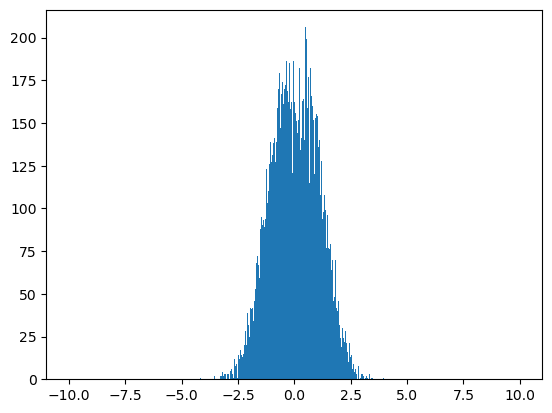

In [231]:
_=plt.hist(gendata_bg_x_shuffled[:,0],bins=bins)

In [301]:
gendata=np.concatenate((gendata_sig,gendata_bg))
genlabels=np.concatenate((np.ones(len(gendata_sig)),np.zeros(len(gendata_bg))))

In [302]:
gendata.shape

(256000, 11)

In [306]:
problist_sig_gen=getprob(gendata,model_sig,normed=True)
problist_bg_gen=getprob(gendata,model_bg,normed=True)

logp_sig_gen=np.log(problist_sig_gen)
logp_bg_gen=np.log(problist_bg_gen)

In [307]:
LR_opt=logp_sig_gen-logp_bg_gen

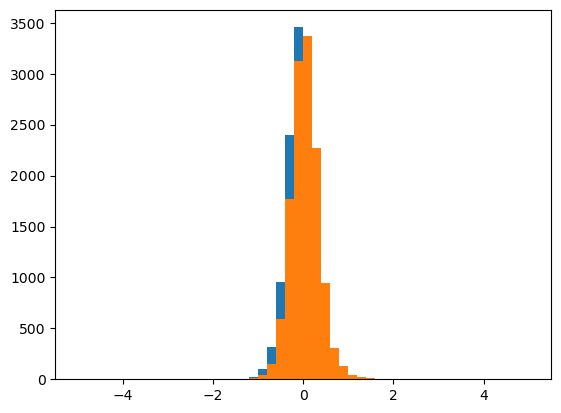

In [49]:
_=plt.hist(LR_opt[genlabels==0],bins=50,range=[-5,5])
_=plt.hist(LR_opt[genlabels==1],bins=50,range=[-5,5])

0.6337095377197266


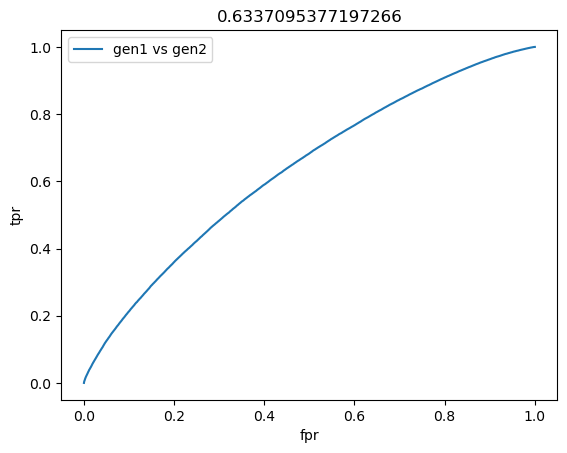

In [308]:
auc=roc_auc_score(genlabels,LR_opt)
print(auc)
fpr,tpr,_=roc_curve(genlabels,LR_opt)
plt.plot(fpr,tpr,label='gen1 vs gen2')
plt.title(auc)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

In [76]:
testdata_raw

array([[ 0.9392399 , -2.27835636,  1.24006507, ...,  0.12966788,
        -0.30365117,  0.12272557],
       [ 0.84098647, -0.42246256, -0.45905708, ...,  1.41094802,
         0.19551458,  0.49439257],
       [ 1.59227505,  0.15121434, -1.36088563, ...,  0.46105008,
        -0.32017983,  0.35789806],
       ...,
       [ 0.0846244 , -1.37379307,  0.38497657, ..., -1.3874165 ,
        -0.0339544 , -0.69951488],
       [ 0.58899092,  0.03174536,  0.9151715 , ...,  2.09970311,
        -0.79507511,  0.61974529],
       [ 0.37640086,  1.84551719, -0.02984511, ..., -0.27200464,
        -0.31965422,  1.61543184]])

In [86]:
gendata_sig_x.shape

(12800, 10)

In [ ]:
# Fourier transform

In [310]:
dx=0.01
xgrid=np.arange(-10,10,dx)
ysamples=np.random.normal(size=(5000,ndim-1))
xydata=np.array([np.concatenate(([[x],y])) for x in xgrid for y in ysamples]) #.reshape((len(xgrid),len(ysamples),10))
pofxgrid=np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)*dx


In [311]:
problist=getprob_fromraw(xydata,model_bg,normed=True)
problist=problist/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
ftxlist_bg_x2000=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  

problist=getprob_fromraw(xydata,model_sig,normed=True)
problist=problist/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
ftxlist_sig_x2000=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  

   

In [459]:
dx=0.01
xgrid=np.arange(-10,10,dx)

klist=np.arange(0,200,2*np.pi/20)+np.pi/20

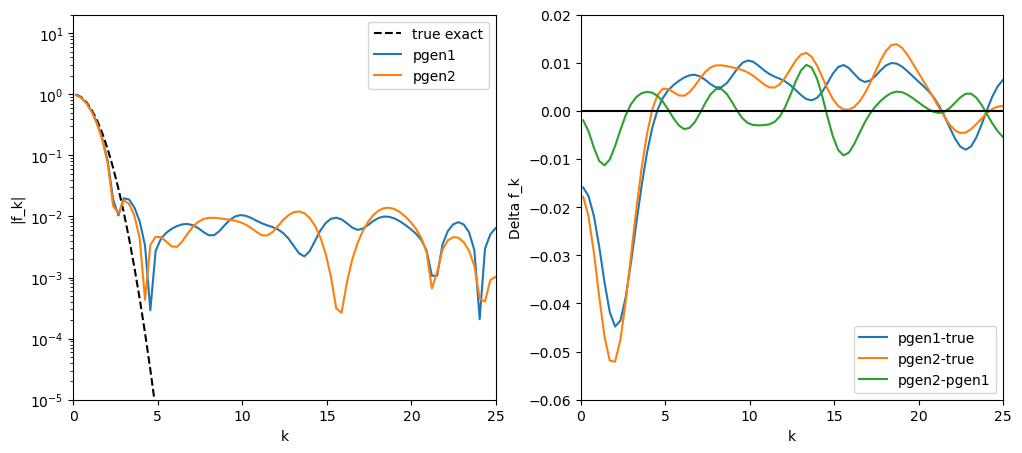

In [467]:
freqlist=np.array([[np.cos(xx*k) for xx in xgrid] for k in klist])
colors = plt.cm.viridis(np.linspace(0,1,5))

fig,ax=plt.subplots(1,2,figsize=(12,5))

ax[0].plot(klist,np.abs(np.exp(-klist**2/2)),label='true exact',color='black',linestyle='dashed')
#plt.plot(klist,np.abs(ftlist_true_hybrid),label='true logp, hybrid euler/mc')
ax[0].plot(klist,np.abs(freqlist@ftxlist_bg_x2000),label='pgen1')
ax[0].plot(klist,np.abs(freqlist@ftxlist_sig_x2000),label='pgen2')
#plt.plot(klist,np.abs(freqlist@ftxlist_sig_x2000[-1]),label='logpsig, hybrid euler/mc')
ax[0].set_yscale('log')
ax[0].set_ylim(1e-5,20)
ax[0].set_xlim(0,25)
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('|f_k|')


#plt.plot(klist,np.exp(-klist**2/2),label='true exact',color='black',linestyle='dashed')
#plt.plot(klist,np.abs(ftlist_true_hybrid),label='true logp, hybrid euler/mc')
ax[1].plot(klist,(freqlist@ftxlist_bg_x2000)-np.exp(-klist**2/2),label='pgen1-true')
ax[1].plot(klist,(freqlist@ftxlist_sig_x2000)-np.exp(-klist**2/2),label='pgen2-true')
ax[1].plot(klist,(freqlist@ftxlist_sig_x2000)-(freqlist@ftxlist_bg_x2000),label='pgen2-pgen1')
#plt.plot(klist,np.abs(freqlist@ftxlist_sig_x2000[-1]),label='logpsig, hybrid euler/mc')
ax[1].set_xlim(0,25)
#plt.yscale('log')
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('Delta f_k')
ax[1].set_ylim(-0.06,0.02)
ax[1].axhline(0,color='black')

In [312]:
'''
niter=1
dx=0.01
xgrid=np.arange(-10,10,dx)
pofxgrid=np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)*dx

ftxlist_bg_x2000={}
ftxlist_sig_x2000={}
for iiter in range(niter):
    print('iter ',iiter)
    ysamples=np.random.normal(size=(5000,ndim-1))

    ftxlist_bg_x2000[iiter]=np.zeros(len(xgrid))
    for ii in range(len(ysamples)):
        if ii%1000==0:
            print(ii)
        y=ysamples[ii]
    #    if ii%100==0:
    #        print(ii)
        xydata=np.array([np.concatenate(([[x],y])) for x in xgrid])
        problist=getprob_fromraw(xydata,model_bg)
        problist=np.prod(problist,axis=-1)
        logproblist=np.log(problist)-ndim*np.log(20/500)-np.log(factorial(ndim))
        ftxlist_bg_x2000[iiter]+=logproblist*pofxgrid
    ftxlist_bg_x2000[iiter]=ftxlist_bg_x2000[iiter]/len(ysamples)

    
    ftxlist_sig_x2000[iiter]=np.zeros(len(xgrid))
    for ii in range(len(ysamples)):
        if ii%1000==0:
            print(ii)
        y=ysamples[ii]
    #    if ii%100==0:
    #        print(ii)
        xydata=np.array([np.concatenate(([[x],y])) for x in xgrid])
        problist=getprob_fromraw(xydata,model_sig)
        problist=np.prod(problist,axis=-1)
        logproblist=np.log(problist)-ndim*np.log(20/500)-np.log(factorial(ndim))
        ftxlist_sig_x2000[iiter]+=logproblist*pofxgrid
    ftxlist_sig_x2000[iiter]=ftxlist_sig_x2000[iiter]/len(ysamples)

#    xydata=
        
#    ftxlist=np.array([(-xx**2/2-np.sum(y**2/2)+10*np.log(np.sqrt(1/2/np.pi)))*np.exp(-xx**2/2)/np.sqrt(2*np.pi)*dx for ])
#    ftk+=freqlist@ftxlist


"\nniter=1\ndx=0.01\nxgrid=np.arange(-10,10,dx)\npofxgrid=np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)*dx\n\nftxlist_bg_x2000={}\nftxlist_sig_x2000={}\nfor iiter in range(niter):\n    print('iter ',iiter)\n    ysamples=np.random.normal(size=(5000,ndim-1))\n\n    ftxlist_bg_x2000[iiter]=np.zeros(len(xgrid))\n    for ii in range(len(ysamples)):\n        if ii%1000==0:\n            print(ii)\n        y=ysamples[ii]\n    #    if ii%100==0:\n    #        print(ii)\n        xydata=np.array([np.concatenate(([[x],y])) for x in xgrid])\n        problist=getprob_fromraw(xydata,model_bg)\n        problist=np.prod(problist,axis=-1)\n        logproblist=np.log(problist)-ndim*np.log(20/500)-np.log(factorial(ndim))\n        ftxlist_bg_x2000[iiter]+=logproblist*pofxgrid\n    ftxlist_bg_x2000[iiter]=ftxlist_bg_x2000[iiter]/len(ysamples)\n\n    \n    ftxlist_sig_x2000[iiter]=np.zeros(len(xgrid))\n    for ii in range(len(ysamples)):\n        if ii%1000==0:\n            print(ii)\n        y=ysamples[ii]\n    #   

In [353]:
t0=time.time()
bins_t=torch.tensor(bins)
x = torch.tensor(preprocess_raw_to_binned(xydata), dtype=torch.long)
dataset = TensorDataset(x)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=False,num_workers=4)    
npermlistuse=[]
for inputs in dataloader:
    inputs=inputs[0]
    inputs_x=bins_t[(inputs)[:,1:]-1]+delta/2
    counts=batched_bincount(torch.bucketize(torch.abs(inputs_x),bins_t,right=True),1,len(bins_t)+2)
    npermlistuse+=np.prod(factorial(counts.numpy()),axis=-1).tolist()
npermlistuse=np.array(npermlistuse)
t1=time.time()
print(t1-t0)

109.53190541267395


In [ ]:

ftxlist_bg_x2000_ep={}
ftxlist_sig_x2000_ep={}
t0=time.time()


for epoch in [4,9,14,19,24,29,34,39]:
    print('epoch ',epoch)

    model_sig.load_state_dict(torch.load('model_sig_ep_'+str(epoch)+'.pt', weights_only=True))
    model_bg.load_state_dict(torch.load('model_bg_ep_'+str(epoch)+'.pt', weights_only=True))

    problist=getprob_fromraw(xydata,model_bg,normed=True,npermlist=npermlistuse)
    t1=time.time()
    print(t1-t0)
    problist=problist/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
    ftxlist_bg_x2000_ep[epoch]=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  

    problist=getprob_fromraw(xydata,model_sig,normed=True,npermlist=npermlistuse)
    t1=time.time()
    print(t1-t0)
    problist=problist/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
    ftxlist_sig_x2000_ep[epoch]=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  

   

In [418]:

t0=time.time()

# init needs to be treated separately, since model hasn't seen the data, don't normalize it with combinatorial factors

for epoch in [-1]:
    print('epoch ',epoch)

    model_sig.load_state_dict(torch.load('model_sig_init.pt', weights_only=True))
    model_bg.load_state_dict(torch.load('model_bg_init.pt', weights_only=True))

    problist=getprob_fromraw(xydata,model_bg,normed=False)/(((20/nbins)**ndim))
    t1=time.time()
    print(t1-t0)
    problist=problist/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
    ftxlist_bg_x2000_ep[epoch]=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  

    problist=getprob_fromraw(xydata,model_sig,normed=False)
    t1=time.time()
    print(t1-t0)
    problist=problist/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
    ftxlist_sig_x2000_ep[epoch]=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  

   

epoch  -1
37.174145460128784
75.52223229408264


In [428]:
len(ftxlist_sig_x2000_ep[-1])

2000

In [427]:
(np.sum(ftxlist_sig_x2000_ep[-1]/((20/nbins)**ndim)))**2/(np.sum((ftxlist_sig_x2000_ep[-1]/((20/nbins)**ndim))**2))

1587.140503277979

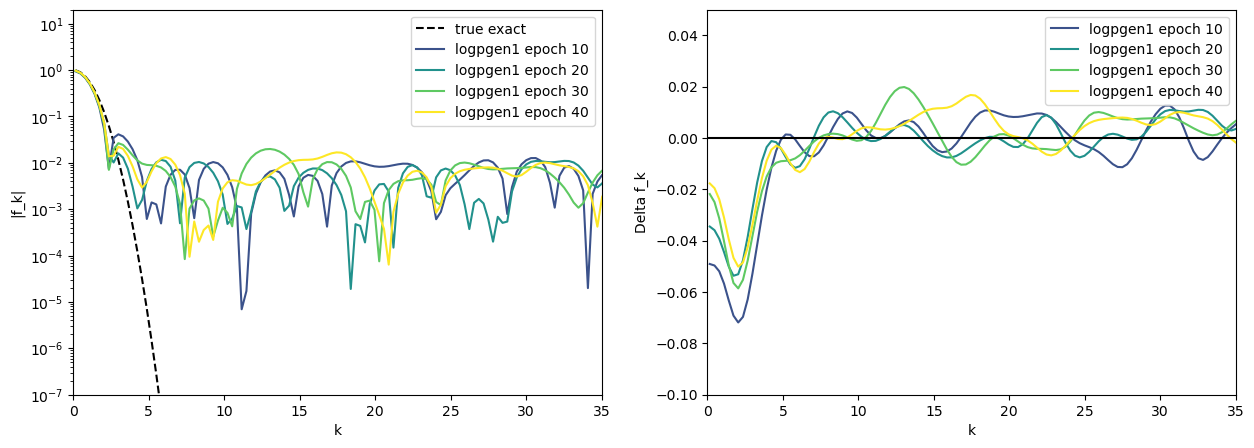

In [474]:
dx=0.01
klist=np.arange(0,200,2*np.pi/20)+np.pi/20
xgrid=np.arange(-10,10,dx)
freqlist=np.array([[np.cos(xx*k) for xx in xgrid] for k in klist])
colors = plt.cm.viridis(np.linspace(0,1,5))

fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(klist,np.abs(np.exp(-klist**2/2)),label='true exact',color='black',linestyle='dashed')
#plt.plot(klist,np.abs(ftlist_true_hybrid),label='true logp, hybrid euler/mc')
#ax[0].plot(klist,np.abs(freqlist@ftxlist_bg_x2000_ep[-1])/np.sum(ftxlist_bg_x2000_ep[-1]),label='logpgen1 init',color=colors[0])
ax[0].plot(klist,np.abs(freqlist@ftxlist_bg_x2000_ep[9]),label='logpgen1 epoch 10',color=colors[1])
ax[0].plot(klist,np.abs(freqlist@ftxlist_bg_x2000_ep[19]),label='logpgen1 epoch 20',color=colors[2])
ax[0].plot(klist,np.abs(freqlist@ftxlist_bg_x2000_ep[29]),label='logpgen1 epoch 30',color=colors[3])
ax[0].plot(klist,np.abs(freqlist@ftxlist_bg_x2000_ep[39]),label='logpgen1 epoch 40',color=colors[4])
#plt.plot(klist,np.abs(freqlist@ftxlist_sig_x2000[-1]),label='logpsig, hybrid euler/mc')
ax[0].set_yscale('log')
ax[0].set_ylim(1e-7,20)
ax[0].set_xlim(0,35)
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('|f_k|')


#ax[1].plot(klist,np.exp(-klist**2/2),label='true exact',color='black',linestyle='dashed')
#plt.plot(klist,np.abs(ftlist_true_hybrid),label='true logp, hybrid euler/mc')
#ax[1].plot(klist,freqlist@ftxlist_bg_x2000_ep[-1]/np.sum(ftxlist_bg_x2000_ep[-1]),label='logpgen1 init',color=colors[0])
ax[1].plot(klist,freqlist@ftxlist_bg_x2000_ep[9]-np.exp(-klist**2/2),label='logpgen1 epoch 10',color=colors[1])
ax[1].plot(klist,freqlist@ftxlist_bg_x2000_ep[19]-np.exp(-klist**2/2),label='logpgen1 epoch 20',color=colors[2])
ax[1].plot(klist,freqlist@ftxlist_bg_x2000_ep[29]-np.exp(-klist**2/2),label='logpgen1 epoch 30',color=colors[3])
ax[1].plot(klist,freqlist@ftxlist_bg_x2000_ep[39]-np.exp(-klist**2/2),label='logpgen1 epoch 40',color=colors[4])
#plt.plot(klist,np.abs(freqlist@ftxlist_sig_x2000[-1]),label='logpsig, hybrid euler/mc')
#plt.yscale('log')
ax[1].set_ylim(-0.1,0.05)
ax[1].set_xlim(0,35)
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('Delta f_k')
ax[1].axhline(0,color='black')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
          1.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   2.,   0.,   2.,
          1.,   1.,   2.,   3.,  11.,  62., 196., 235.,  40.,  36.,  23.,
          9.,   3.,   4.,   0.,   0.,   0.]),
 array([-0.1   , -0.0975, -0.095 , -0.0925, -0.09  , -0.0875, -0.085 ,
        -0.0825, -0.08  , -0.0775, -0.075 , -0.0725, -0.07  , -0.0675,
        -0.065 , -0.0625, -0.06  , -0.0575, -0.055 , -0.0525, -0.05  ,
        -0.0475, -0.045 , -0.0425, -0.04  , -0.0375, -0.035 , -0.0325,
        -0.03  , -0.0275, -0.025 , -0.0225, -0.02  , -0.0175, -0.015 ,
        -0.0125, -0.01  , -0.0075, -0.005 , -0.0025,  0.    ,  0.0025,
         0.005 ,  0.0075,  0.01  ,  0.0125,  0.015 ,  0.0175,  0.02  ,
         0.0225,  0.025 ]),
 <BarContainer object of 50 artists>)

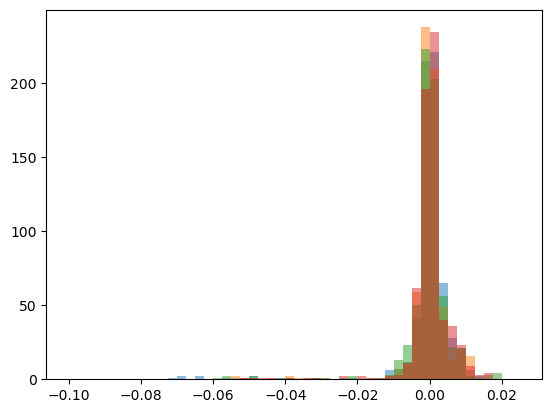

In [441]:
plt.hist(freqlist@ftxlist_bg_x2000_ep[9]-np.exp(-klist**2/2),range=[-0.1,0.025],bins=50,alpha=0.5)
plt.hist(freqlist@ftxlist_bg_x2000_ep[19]-np.exp(-klist**2/2),range=[-0.1,0.025],bins=50,alpha=0.5)
plt.hist(freqlist@ftxlist_bg_x2000_ep[29]-np.exp(-klist**2/2),range=[-0.1,0.025],bins=50,alpha=0.5)
plt.hist(freqlist@ftxlist_bg_x2000_ep[39]-np.exp(-klist**2/2),range=[-0.1,0.025],bins=50,alpha=0.5)
#plt.yscale('log')

In [417]:
np.sum(ftxlist_bg_x2000_ep[-1])

3.4532245542567706e-11

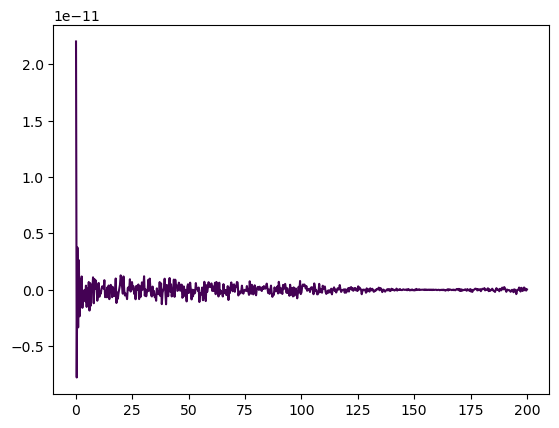

In [407]:
plt.plot(klist,freqlist@ftxlist_bg_x2000_ep[-1],label='logpgen1 init',color=colors[0])


In [442]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


In [447]:
niter=1
dx=0.001
xgrid=np.arange(-3,3,dx)
pofxgrid=np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)*dx
ysamples=np.random.normal(size=(1,ndim-1))
xydata_temp=np.array([np.concatenate(([[x],y])) for x in xgrid])

model_bg.load_state_dict(torch.load('model_bg_ep_'+str(39)+'.pt', weights_only=True))


problist=getprob_fromraw(xydata_temp,model_bg,normed=True)
logproblist=np.log(problist)




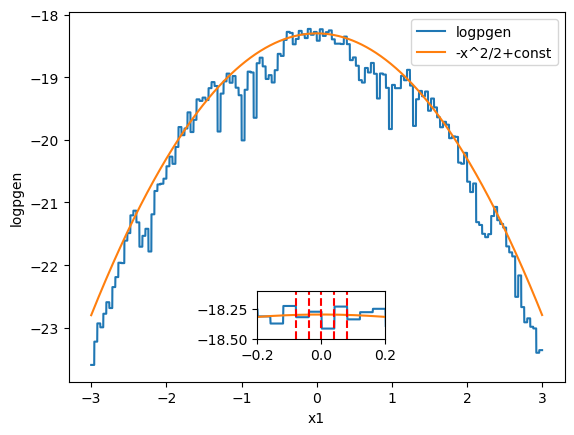

In [458]:
fig,ax=plt.subplots()

xgrid=np.arange(-3,3,dx)

ax.plot(xgrid,logproblist,label='logpgen')
ax.plot(xgrid,-xgrid**2/2-18.3,label='-x^2/2+const')
#plt.ylim(-10,0)
ax.set_ylabel('logpgen')
ax.set_xlabel('x1')
ax.legend()


ax2=fig.add_axes([0.42,0.2,0.2,0.1])
ax2.plot(xgrid,logproblist,label='logpgen')
ax2.plot(xgrid,-xgrid**2/2-18.3,label='-x^2/2+const')
ax2.set_ylim(-18.5,-18.1)
ax2.set_xlim(-0.2,0.2)
ax2.axvline(bins[248],color='r',linestyle='dashed')
ax2.axvline(bins[249],color='r',linestyle='dashed')
ax2.axvline(bins[250],color='r',linestyle='dashed')
ax2.axvline(bins[251],color='r',linestyle='dashed')
ax2.axvline(bins[252],color='r',linestyle='dashed')
# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
#mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")


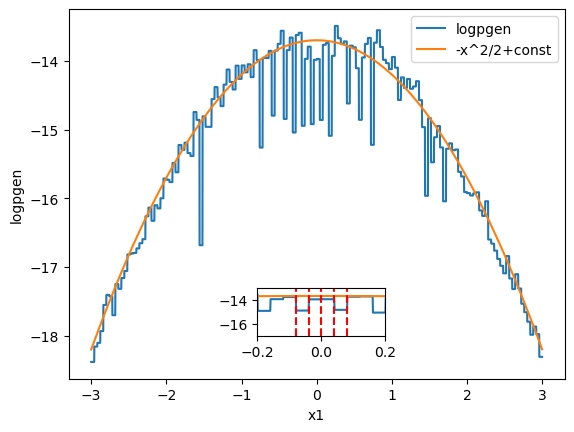

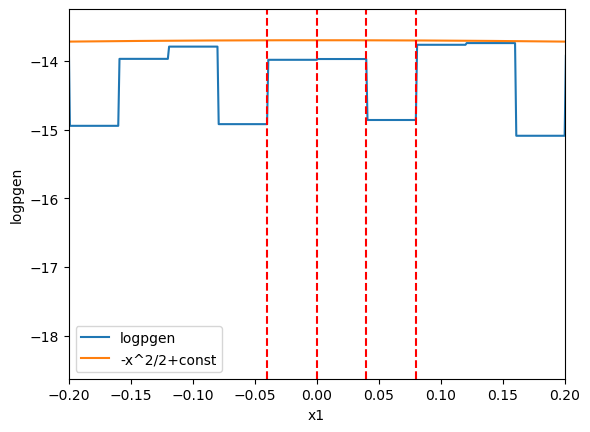

In [103]:
xgrid=np.arange(-3,3,dx)



(0.0, 50.0)

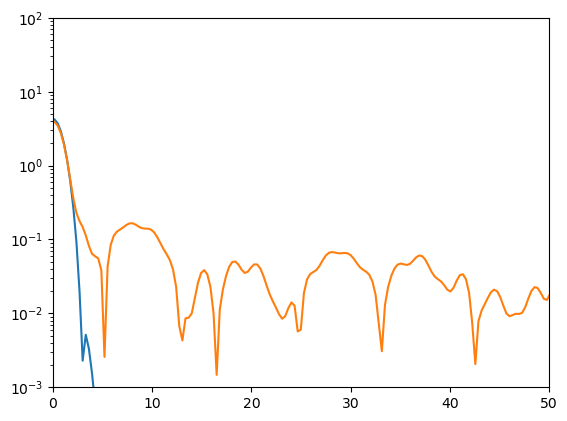

In [84]:
freqlist=np.array([[np.cos(xx*k) for xx in xgrid] for k in klist])

plt.plot(klist,np.abs(ftlist_true_exact[:,1]),label='true exact')
plt.plot(klist,np.abs(freqlist@ftxlist_sig_temp[0]))
plt.yscale('log')
plt.ylim(1e-3,100)
plt.xlim(0,50)

(0.0, 50.0)

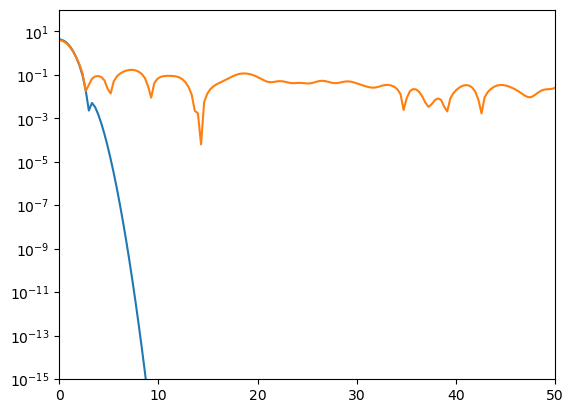

In [66]:
plt.plot(klist,np.abs(ftlist_true_exact[:,1]),label='true exact')
plt.plot(klist,np.abs(freqlist@ftxlist_sig_temp[0]))
plt.yscale('log')
plt.ylim(1e-15,100)
plt.xlim(0,50)

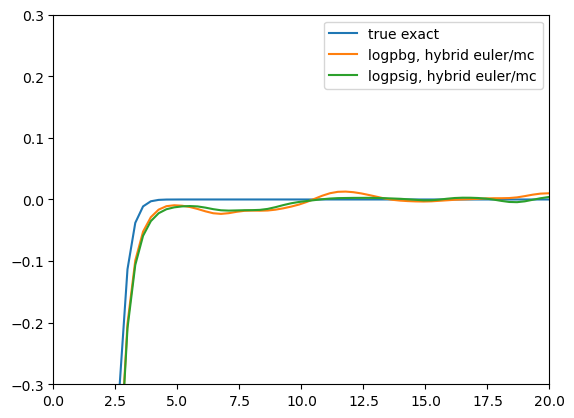

In [73]:
plt.plot(klist,ftlist_true_exact[:,1],label='true exact')
#plt.plot(klist,ftlist_true_hybrid,label='true logp, hybrid euler/mc')
plt.plot(klist,ftlist_bg_x2000[0],label='logpbg, hybrid euler/mc')
plt.plot(klist,ftlist_sig_x2000[0],label='logpsig, hybrid euler/mc')
#plt.yscale('log')
#plt.ylim(1e-7,100)
plt.ylim(-0.3,0.3)
plt.xlim(0,20)
plt.legend()

In [617]:
sigma=0.01
Nmu=50
musample=np.random.normal(size=(Nmu,10))*0.1
toydata_gen=[]
for mu in musample:
    toydata_gen.append(np.random.normal(size=(100//Nmu,10))*sigma+mu)
toydata_gen.append(np.random.normal(size=(9900,10)))
toydata_gen=np.concatenate((toydata_gen))

toydata_ref=np.random.normal(size=(10000,10))

toydata=np.concatenate((toydata_gen,toydata_ref))
toylabels=np.concatenate((np.ones(len(toydata_gen)),np.zeros(len(toydata_ref))))

from scipy.special import logsumexp
logptoygen=(torch.logsumexp(torch.tensor([-np.sum((toydata-mu)**2,axis=-1)/(2*sigma**2)\
                                -10*np.log(np.sqrt(2*np.pi*sigma**2)) for mu in musample]),dim=0).numpy())-np.log(Nmu)
logptoygen=torch.logsumexp(torch.tensor([logptoygen+np.log(1/100),-np.sum(toydata**2,axis=-1)/2-10*np.log(np.sqrt(2*np.pi))+np.log(99/100)]),dim=0)
logptoyref=-np.sum(toydata**2,axis=-1)/2-10*np.log(np.sqrt(2*np.pi))

In [448]:
Nmu

1000

In [444]:
torch.tensor([-np.sum((toydata-mu)**2,axis=-1)/(2*sigma**2)\
                                -10*np.log(np.sqrt(2*np.pi*sigma**2)) for mu in musample]).shape

torch.Size([1000, 20000])

(array([ 400.,    0.,  800., 1599., 1201., 1200., 1200., 1600., 1200.,
         800.]),
 array([-2.68033746, -2.23901053, -1.7976836 , -1.35635667, -0.91502974,
        -0.47370281, -0.03237588,  0.40895105,  0.85027798,  1.29160491,
         1.73293184]),
 <BarContainer object of 10 artists>)

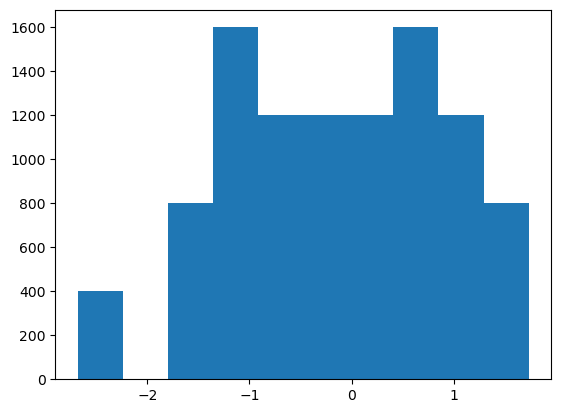

In [325]:
plt.hist(toydata_gen[:,2])

In [378]:
sigma=1.0
toydata_gen=np.random.normal(size=(10000,10))*sigma

toydata_ref=np.random.normal(size=(10000,10))

toydata=np.concatenate((toydata_gen,toydata_ref))
toylabels=np.concatenate((np.ones(len(toydata_gen)),np.zeros(len(toydata_ref))))

logptoygen=-np.sum((toydata)**2,axis=-1)/(2*sigma**2)-10*np.log(np.sqrt(2*np.pi*sigma**2))
logptoyref=-np.sum(toydata**2,axis=-1)/2-10*np.log(np.sqrt(2*np.pi))

In [159]:
mu=1
sigma=0.1
toydata_gen=np.concatenate((np.random.normal(size=(9900,10)),sigma*np.random.normal(size=(100,10))+mu))
toydata_ref=np.random.normal(size=(10000,10))


In [313]:
LR_genvsref[toylabels==1].shape

(10000,)

(array([2.000e+00, 1.100e+01, 1.800e+01, 7.000e+01, 2.570e+02, 7.480e+02,
        1.885e+03, 3.365e+03, 3.014e+03, 6.300e+02]),
 array([-28.45947367, -26.55268707, -24.64590046, -22.73911385,
        -20.83232725, -18.92554064, -17.01875404, -15.11196743,
        -13.20518082, -11.29839422,  -9.39160761]),
 <BarContainer object of 10 artists>)

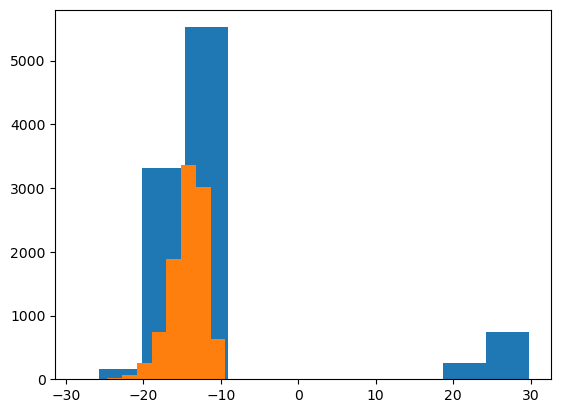

In [614]:
plt.hist(logptoygen[toylabels==1])
plt.hist(logptoyref[toylabels==0])


(array([5001.,    0.,    8.,   43.,  255.,  878., 1876., 1329.,  492.,
         118.]),
 array([-0.69314718,  2.07609956,  4.84534631,  7.61459305, 10.3838398 ,
        13.15308654, 15.92233329, 18.69158003, 21.46082677, 24.23007352,
        26.99932026]),
 <BarContainer object of 10 artists>)

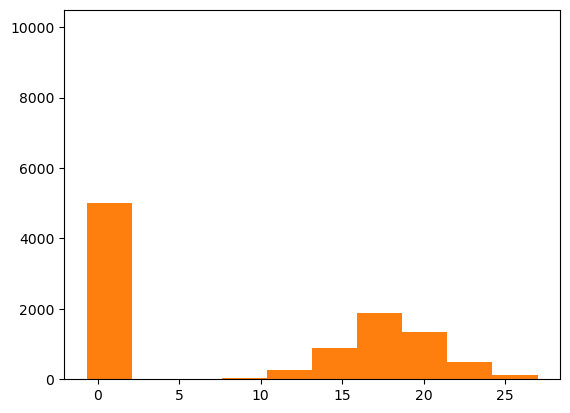

In [587]:
plt.hist(LR_genvsref[toylabels==0])
plt.hist(LR_genvsref[toylabels==1])

In [615]:
LR_genvsref=logptoygen-logptoyref

0.54928


Text(0.5, 1.0, '0.54928')

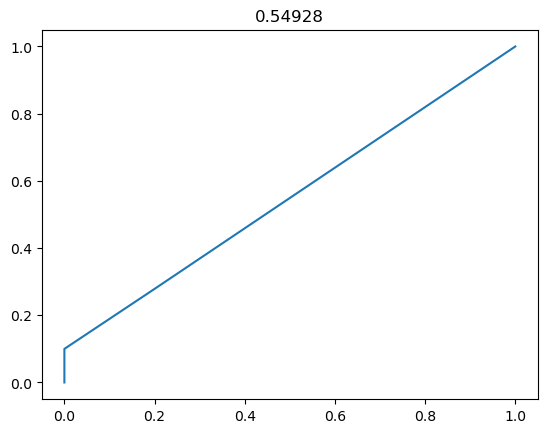

In [616]:
auc=roc_auc_score(toylabels,LR_genvsref)
print(auc)
fpr,tpr,_=roc_curve(toylabels,LR_genvsref)
plt.plot(fpr,tpr)
plt.title(auc)

In [611]:
fklist=np.array([np.sum([np.exp(-k**2*sigma**2/2)*np.cos(k*mu[0]) for mu in musample]) for k in klist])

(0.0, 50.0)

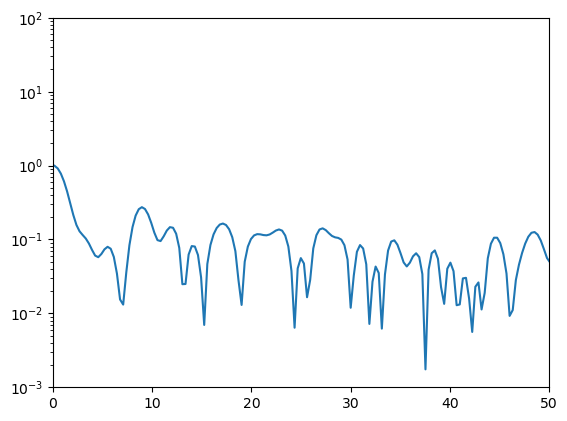

In [612]:
plt.plot(klist,np.abs(fklist)/50)
plt.yscale('log')
plt.ylim(1e-3,100)
plt.xlim(0,50)

In [ ]:
# suppose f_|k| is given by e^{-k^2/2} + epsilon e^{-k^2/2sigma^2} cos |k|mu for some mu
# FT this back to position space
# f(x)=\int d^3 k f_|k| e^{i k.x} 
# this is even in x so we lose nothing by FTing wrt cos k x
# f(x)=\int d^3k f_|k| cos k.x
# f(x) = e^{-x^2/2} + epsilon*(e^{-(|x|-mu)^2/(2sigma^2)}(|x|-mu)/|x|+e^{-(|x|+mu)^2/(2sigma^2)}(|x|+mu)/|x|)
#
# sample from this by first sampling |x| from [0,\infty] and then sampling costheta,phi from uniform
# careful: if this is f( x)d^3x, then in radial coordinates we should sample from x^2 f(x). 

In [ ]:
# let's try: logpmodel = -x^2/2+\epsilon*cos k0|x| + const
# need rejection sampling

In [475]:
def target_distribution(x,eps,k0):
    """Unnormalized target distribution (mixture of two Gaussians)."""
    return np.exp(-np.sum(x**2)/2+eps*np.cos(k0*np.sqrt(np.sum(x**2))))/(np.sqrt(2*np.pi))**ndim

def proposal_distribution(x):
    """Proposal distribution (Gaussian)."""
    return np.exp(-np.sum(x**2)/2)/(np.sqrt(2*np.pi))**ndim

def rejection_sampling(num_samples, eps,k0,k):
    """Rejection sampling algorithm."""
    samples = []
    while len(samples) < num_samples:
        # Sample from the proposal distribution
        z = np.random.normal(loc=0, scale=1,size=ndim)
        # Sample from a uniform distribution
        u = np.random.uniform(0, k * proposal_distribution(z))

        # Accept or reject the sample
        if u <= target_distribution(z, eps,k0):
            samples.append(z)
    return np.array(samples)

In [ ]:
# the ratio of target/proposal is e^{eps*cos(k0|x|)} which takes a maximum value of e^{eps} at k0|x| = 2*pi*n

In [57]:
np.exp(0.6)

1.8221188003905089

In [477]:
k0=10
eps=0.6
gendata1=rejection_sampling(20000,eps,k0,np.exp(eps))

k0=20
eps=0.6
gendata2=rejection_sampling(20000,eps,k0,np.exp(eps))

In [60]:
gendata1.shape

(20000, 10)

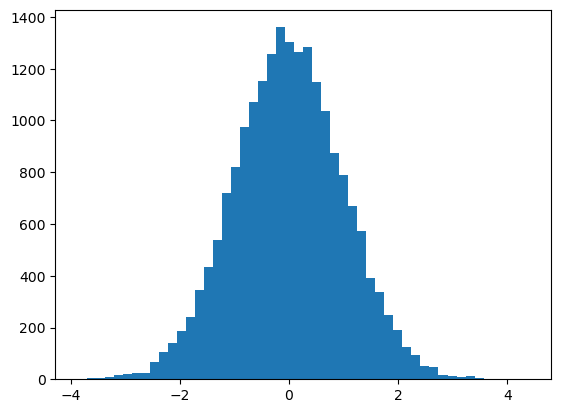

In [478]:
_=plt.hist(gendata1[:,0],bins=50)

In [479]:
refdata=np.random.normal(size=(20000,ndim))

In [480]:
alldata=np.concatenate((gendata1,refdata))
alllabels=np.concatenate((np.ones(len(gendata1)),np.zeros(len(refdata))))

In [481]:
k0=10
eps=0.6
logpgen=-np.sum(alldata**2,axis=-1)/2+eps*np.cos(k0*np.sqrt(np.sum(alldata**2,axis=-1)))
logpref=-np.sum(alldata**2,axis=-1)/2
logRopt=logpgen-logpref

In [482]:
fpr,tpr,_=roc_curve(alllabels,logRopt)
auc=roc_auc_score(alllabels,logRopt)
print(auc)

0.61572416


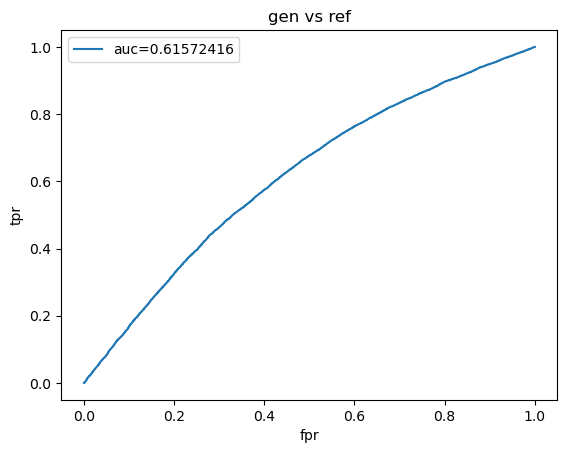

In [483]:
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.title('gen vs ref')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

0.6472533675000001


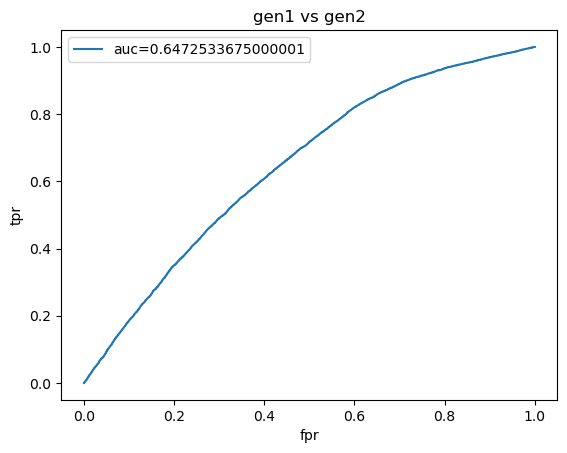

In [484]:
alldata=np.concatenate((gendata1,gendata2))
alllabels=np.concatenate((np.ones(len(gendata1)),np.zeros(len(gendata2))))

k0=10
eps=0.6
logpgen1=-np.sum(alldata**2,axis=-1)/2+eps*np.cos(k0*np.sqrt(np.sum(alldata**2,axis=-1)))

k0=20
eps=0.6
logpgen2=-np.sum(alldata**2,axis=-1)/2+eps*np.cos(k0*np.sqrt(np.sum(alldata**2,axis=-1)))
logRopt=logpgen1-logpgen2

fpr,tpr,_=roc_curve(alllabels,logRopt)
auc=roc_auc_score(alllabels,logRopt)
print(auc)

plt.plot(fpr,tpr,label='auc='+str(auc))
plt.title('gen1 vs gen2')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

In [485]:
dx=0.01
xgrid=np.arange(-10,10,dx)
ysamples=np.random.normal(size=(5000,ndim-1))
xydata=np.array([np.concatenate(([[x],y])) for x in xgrid for y in ysamples]) #.reshape((len(xgrid),len(ysamples),10))
pofxgrid=np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)*dx


In [489]:

eps=0.6
k0=10
normconst=10694/9792.63
problist=np.exp(eps*np.cos(k0*np.sqrt(np.sum(xydata**2,axis=-1))))/normconst
ftxlist_gen1=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  

eps=0.6
k0=20
normconst=10694/9792.63
problist=np.exp(eps*np.cos(k0*np.sqrt(np.sum(xydata**2,axis=-1))))/normconst
ftxlist_gen2=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  

   

In [490]:
freqlist=np.array([[np.cos(xx*k) for xx in xgrid] for k in klist])


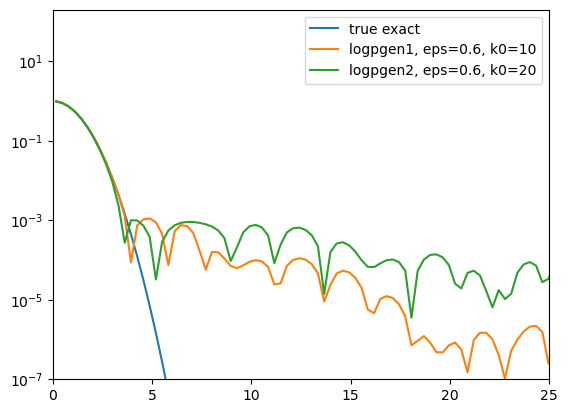

In [491]:
plt.plot(klist,np.exp(-klist**2/2),label='true exact')
#plt.plot(klist,np.abs(ftlist_true_hybrid),label='true logp, hybrid euler/mc')
plt.plot(klist,np.abs(freqlist@ftxlist_gen1),label='logpgen1, eps=0.6, k0=10')
plt.plot(klist,np.abs(freqlist@ftxlist_gen2),label='logpgen2, eps=0.6, k0=20')
plt.yscale('log')
plt.ylim(1e-7,200)
plt.xlim(0,25)
plt.legend()

In [ ]:
# A fun side study: does repeated training and sampling increase the artifacts and widen the gap between ref and gen?

In [183]:
def train_model(model,traindata,testdata,epochs=50):
    X_train = torch.tensor(traindata, dtype=torch.long)
    X_test = torch.tensor(testdata, dtype=torch.long)
    train_dataset = TensorDataset(X_train)
    test_dataset = TensorDataset(X_test)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    model.to(device)
    # 3. Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 4. Train the model
    losslist=[]
    bestloss=99999
    
    for epoch in range(epochs):
        model.train()
        for inputs in train_loader:
            optimizer.zero_grad()
            # Forward pass
            inputs2=torch.transpose(inputs[0],0,1)
            src_mask = model.generate_square_subsequent_mask(inputs2.size(0))
    
    
            
            outputs = model(inputs2.to(device),src_mask.to(device))
    #        print(outputs.shape)
    #        print(inputs2.shape)
            loss = criterion(outputs[:-1].reshape(-1, ntoken),inputs2[1:].reshape(-1).to(device))
    
            # Backward and optimize
            loss.backward()
            optimizer.step()
    
        model.eval()
        with torch.no_grad():
            loss=0
            nbatch=0
            for inputs in test_loader:
                inputs2=torch.transpose(inputs[0],0,1)
                src_mask = model.generate_square_subsequent_mask(inputs2.size(0))
    
                outputs = model(inputs2.to(device),src_mask.to(device))
                loss+=criterion(outputs[:-1].reshape(-1, ntoken),inputs2[1:].reshape(-1).to(device))
                nbatch+=1
            loss=loss/nbatch
            losslist.append(loss.detach().cpu().numpy())
            
            print('Epoch, Loss of the model on the test data: ',epoch,loss)
            if loss<bestloss:
                bestloss=loss
                print('best loss ',bestloss)


In [492]:
len(traindata[trainlabels==1]),\
len(testdata[testlabels==1])


(100039, 49961)

In [494]:
models_iter={}
traind=traindata[trainlabels==1]
testd=testdata[testlabels==1]

for iiter in range(5):
    print(iiter,traind.shape,testd.shape)
    models_iter[iiter]=IntegerSequencePredictor(ntoken, ninp, nhead, nhid, nlayers)
    train_model(models_iter[iiter],traind,testd)
    
    gend=[]
    batch_size=128
    for ii in range(1200):
        if ii%100==0:
            print(ii)
        gend.append(generate_batch_sequences_autoregressively(models_iter[iiter], \
                                        (np.ones(batch_size)*(ntoken-1)).reshape((-1,1)).astype('int').tolist(), ndim+1, temperature=1))
    gend=np.array(gend).reshape((-1,ndim+1))

    traind=gend[:100000]
    testd=gend[100000:]

    


0 (100039, 11) (49961, 11)
Epoch, Loss of the model on the test data:  0 tensor(3.2593, device='cuda:0')
best loss  tensor(3.2593, device='cuda:0')
Epoch, Loss of the model on the test data:  1 tensor(3.2434, device='cuda:0')
best loss  tensor(3.2434, device='cuda:0')
Epoch, Loss of the model on the test data:  2 tensor(3.2391, device='cuda:0')
best loss  tensor(3.2391, device='cuda:0')
Epoch, Loss of the model on the test data:  3 tensor(3.2334, device='cuda:0')
best loss  tensor(3.2334, device='cuda:0')
Epoch, Loss of the model on the test data:  4 tensor(3.2292, device='cuda:0')
best loss  tensor(3.2292, device='cuda:0')
Epoch, Loss of the model on the test data:  5 tensor(3.2264, device='cuda:0')
best loss  tensor(3.2264, device='cuda:0')
Epoch, Loss of the model on the test data:  6 tensor(3.2268, device='cuda:0')
Epoch, Loss of the model on the test data:  7 tensor(3.2226, device='cuda:0')
best loss  tensor(3.2226, device='cuda:0')
Epoch, Loss of the model on the test data:  8 te

In [495]:
for iiter in range(5):
    torch.save(models_iter[iiter].state_dict(),"model_iter"+str(iiter)+".pt")
    torch.save(models_iter[iiter].state_dict(),"model_iter"+str(iiter)+".pt")

0
0
0
0
0


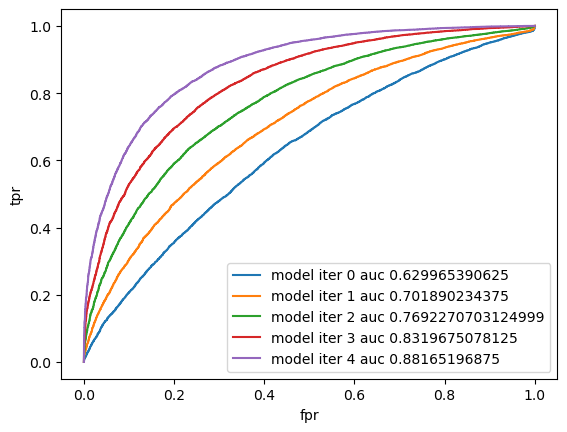

In [497]:
for iiter in range(5):
    gend=[]
    batch_size=128
    for ii in range(100):
        if ii%100==0:
            print(ii)
        gend.append(generate_batch_sequences_autoregressively(models_iter[iiter], \
                                        (np.ones(batch_size)*(ntoken-1)).reshape((-1,1)).astype('int').tolist(), ndim+1, temperature=1))
    gend=np.array(gend).reshape((-1,ndim+1))
    gend_x=bins[np.clip(gend[:,1:],a_min=None,a_max=499)-1]+delta/2
    
    prob_gensample_genmodel=getprob(gend,models_iter[iiter],normed=True)
    prob_refsample_genmodel=getprob_fromraw(moredata[:10000],models_iter[iiter],normed=True)


    prob_genmodel=np.concatenate((prob_gensample_genmodel,prob_refsample_genmodel))
    logp_genmodel=np.log(prob_genmodel)

    logp_refmodel=-np.sum(np.concatenate((gend_x,moredata[:10000]))**2,axis=-1)/2

    labels=np.concatenate((np.ones(len(gend)),np.zeros(10000)))

    auc=roc_auc_score(labels,logp_genmodel-logp_refmodel)
    fpr,tpr,_=roc_curve(labels,logp_genmodel-logp_refmodel)
    
    plt.plot(fpr,tpr,label='model iter '+str(iiter)+' auc '+str(auc))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

In [498]:
dx=0.01
xgrid=np.arange(-10,10,dx)
ysamples=np.random.normal(size=(5000,ndim-1))
xydata=np.array([np.concatenate(([[x],y])) for x in xgrid for y in ysamples]) #.reshape((len(xgrid),len(ysamples),10))
pofxgrid=np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)*dx


In [499]:
t0=time.time()
bins_t=torch.tensor(bins)
x = torch.tensor(preprocess_raw_to_binned(xydata), dtype=torch.long)
dataset = TensorDataset(x)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=False,num_workers=4)    
npermlistuse=[]
for inputs in dataloader:
    inputs=inputs[0]
    inputs_x=bins_t[(inputs)[:,1:]-1]+delta/2
    counts=batched_bincount(torch.bucketize(torch.abs(inputs_x),bins_t,right=True),1,len(bins_t)+2)
    npermlistuse+=np.prod(factorial(counts.numpy()),axis=-1).tolist()
npermlistuse=np.array(npermlistuse)
t1=time.time()
print(t1-t0)

113.03134036064148


In [506]:
ftxlist_geniter_x2000={}
for iiter in range(5):
    print('iiter ',iiter)

    problist=getprob_fromraw(xydata,models_iter[iiter],normed=True,npermlist=npermlistuse)
    problist=problist/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
    ftxlist_geniter_x2000[iiter]=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  


iiter  0
iiter  1
iiter  2
iiter  3
iiter  4


Text(0, 0.5, '|f_k|')

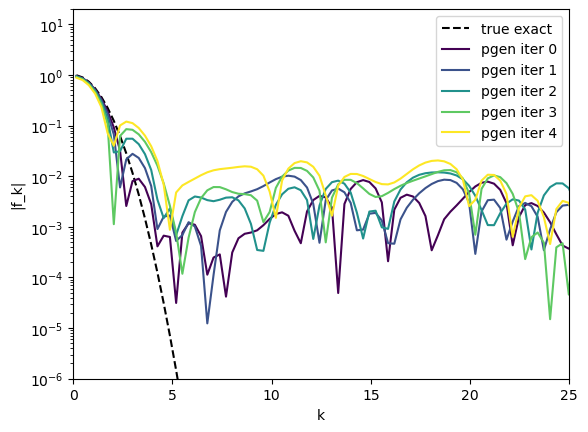

In [512]:
freqlist=np.array([[np.cos(xx*k) for xx in xgrid] for k in klist])
colors = plt.cm.viridis(np.linspace(0,1,5))


plt.plot(klist,np.exp(-klist**2/2),label='true exact',color='black',linestyle='dashed')
for iiter in range(5):
    plt.plot(klist,np.abs(freqlist@ftxlist_geniter_x2000[iiter]),label='pgen iter '+str(iiter),color=colors[iiter])
plt.yscale('log')
plt.ylim(1e-6,20)
plt.xlim(0,25)
plt.legend()
plt.xlabel('k')
plt.ylabel('|f_k|')


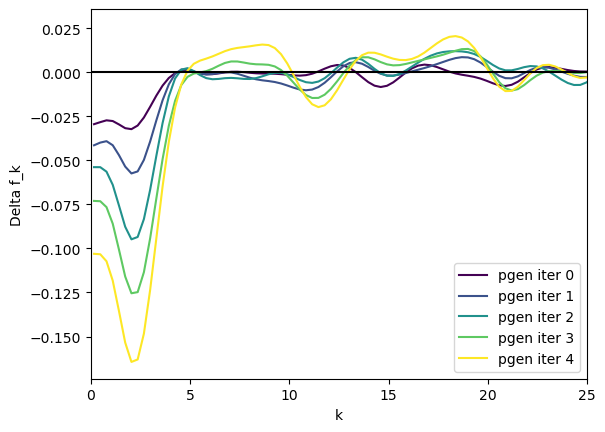

In [511]:
freqlist=np.array([[np.cos(xx*k) for xx in xgrid] for k in klist])
colors = plt.cm.viridis(np.linspace(0,1,5))


#plt.plot(klist,np.exp(-klist**2/2),label='true exact',color='black',linestyle='dashed')
for iiter in range(5):
    plt.plot(klist,freqlist@ftxlist_geniter_x2000[iiter]-np.exp(-klist**2/2),label='pgen iter '+str(iiter),color=colors[iiter])
#plt.yscale('log')
#plt.ylim(1e-5,200)
plt.xlim(0,25)
plt.legend()
plt.xlabel('k')
plt.ylabel('Delta f_k')
plt.axhline(0,color='black')


In [ ]:
# dependence on bin spacing

In [248]:
model_sig_nbins={}
model_bg_nbins={}
ndim=10

sigdata_raw=np.random.normal(size=(150000,ndim))
bgdata_raw=np.random.normal(size=(150000,ndim))
alldata_raw=np.concatenate((sigdata_raw,bgdata_raw))
alllabels=np.concatenate((np.ones(len(sigdata_raw)),np.zeros(len(bgdata_raw))))
perm0=np.random.permutation(len(alldata_raw))

for nbins in [10,50,100,200,500,1000]:
#for nbins in [10,100,1000]:
    ntoken = nbins+2 # Example: integers from 0 to 99
    bins=np.linspace(-10,10,nbins+1)
    delta=bins[1]-bins[0]
    print(delta)

    binneddata_sorted=preprocess_raw_to_binned(alldata_raw)
    traindata=binneddata_sorted[perm0[:200000]]
    trainlabels=alllabels[perm0[:200000]]
    
    testdata=binneddata_sorted[perm0[200000:]]
    testlabels=alllabels[perm0[200000:]]
    
    traindata_raw=alldata_raw[perm0[:200000]]
    testdata_raw=alldata_raw[perm0[200000:]]

    traind=traindata[trainlabels==1]
    testd=testdata[testlabels==1]

    model_sig_nbins[nbins]=IntegerSequencePredictor(ntoken, ninp, nhead, nhid, nlayers)
    train_model(model_sig_nbins[nbins],traind,testd,epochs=50)

    model_bg_nbins[nbins]=IntegerSequencePredictor(ntoken, ninp, nhead, nhid, nlayers)
    train_model(model_bg_nbins[nbins],traind,testd,epochs=50)



2.0


/home/shih/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch, Loss of the model on the test data:  0 tensor(0.7818, device='cuda:0')
best loss  tensor(0.7818, device='cuda:0')
Epoch, Loss of the model on the test data:  1 tensor(0.7818, device='cuda:0')
Epoch, Loss of the model on the test data:  2 tensor(0.7825, device='cuda:0')
Epoch, Loss of the model on the test data:  3 tensor(0.7817, device='cuda:0')
best loss  tensor(0.7817, device='cuda:0')
Epoch, Loss of the model on the test data:  4 tensor(0.7817, device='cuda:0')
best loss  tensor(0.7817, device='cuda:0')
Epoch, Loss of the model on the test data:  5 tensor(0.7816, device='cuda:0')
best loss  tensor(0.7816, device='cuda:0')
Epoch, Loss of the model on the test data:  6 tensor(0.7834, device='cuda:0')
Epoch, Loss of the model on the test data:  7 tensor(0.7817, device='cuda:0')
Epoch, Loss of the model on the test data:  8 tensor(0.7818, device='cuda:0')
Epoch, Loss of the model on the test data:  9 tensor(0.7823, device='cuda:0')
Epoch, Loss of the model on the test data:  10 t

In [249]:
for nbins in [10,50,100,200,500,1000]:
    torch.save(model_sig_nbins[nbins].state_dict(),"model_sig_nbins"+str(nbins)+".pt")
    torch.save(model_bg_nbins[nbins].state_dict(),"model_bg_nbins"+str(nbins)+".pt")

0
0
0
0
0
0


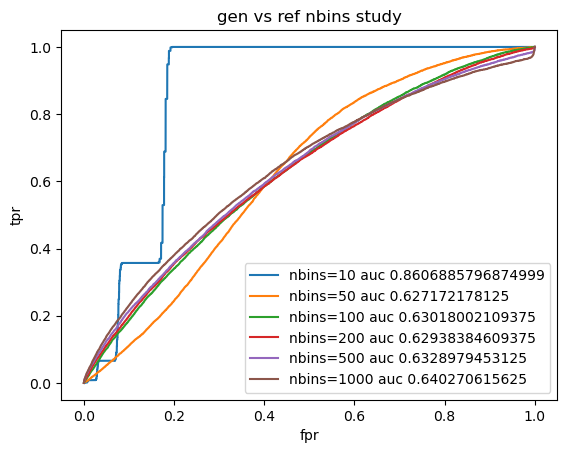

In [250]:
for nbins in [10,50,100,200,500,1000]:
#for nbins in [10,100,1000]:
    ntoken = nbins+2 # Example: integers from 0 to 99
    bins=np.linspace(-10,10,nbins+1)
    delta=bins[1]-bins[0]

#    gensig=[]
#    batch_size=128
#    for ii in range(100):
#        if ii%100==0:
#            print(ii)
#        gensig.append(generate_batch_sequences_autoregressively(model_sig_nbins[nbins], \
#                                        (np.ones(batch_size)*(ntoken-1)).reshape((-1,1)).astype('int').tolist(), ndim+1, temperature=1))
#    gensig=np.array(gensig).reshape((-1,ndim+1))

    genbg=[]
    batch_size=128
    for ii in range(100):
        if ii%100==0:
            print(ii)
        genbg.append(generate_batch_sequences_autoregressively(model_bg_nbins[nbins], \
                                        (np.ones(batch_size)*(ntoken-1)).reshape((-1,1)).astype('int').tolist(), ndim+1, temperature=1))
    genbg=np.array(genbg).reshape((-1,ndim+1))

    genbg_x=bins[np.clip(genbg[:,1:],a_min=None,a_max=nbins-1)-1]+delta/2

    prob_gensample_genmodel=getprob(genbg,model_bg_nbins[nbins],normed=True)
    prob_refsample_genmodel=getprob_fromraw(moredata,model_bg_nbins[nbins],normed=True)
    prob_genmodel=np.concatenate((prob_gensample_genmodel,prob_refsample_genmodel))
    logp_genmodel=np.log(prob_genmodel)

    logp_refmodel=-np.sum(np.concatenate((genbg_x,moredata))**2,axis=-1)/2

    labels=np.concatenate((np.ones(len(genbg)),np.zeros(len(moredata))))
    
    auc=roc_auc_score(labels,logp_genmodel-logp_refmodel)
    fpr,tpr,_=roc_curve(labels,logp_genmodel-logp_refmodel)
    
    plt.plot(fpr,tpr,label='nbins='+str(nbins)+' auc '+str(auc))
    plt.title('gen vs ref nbins study')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend()

0
0
0
0
0
0
0
0
0
0
0
0


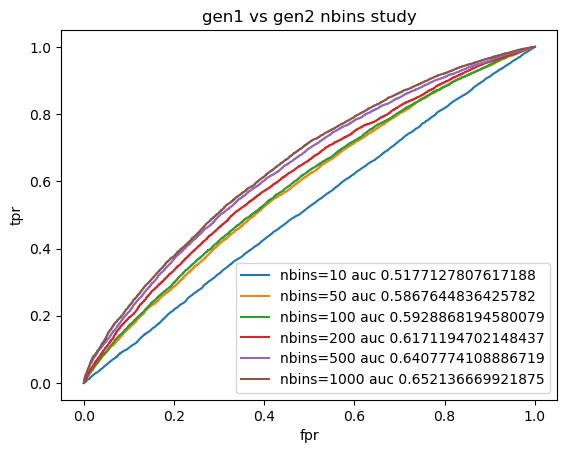

In [251]:
for nbins in [10,50,100,200,500,1000]:
#for nbins in [10,100,1000]:
    ntoken = nbins+2 # Example: integers from 0 to 99
    bins=np.linspace(-10,10,nbins+1)
    delta=bins[1]-bins[0]

    gensig=[]
    batch_size=128
    for ii in range(100):
        if ii%100==0:
            print(ii)
        gensig.append(generate_batch_sequences_autoregressively(model_sig_nbins[nbins], \
                                        (np.ones(batch_size)*(ntoken-1)).reshape((-1,1)).astype('int').tolist(), ndim+1, temperature=1))
    gensig=np.array(gensig).reshape((-1,ndim+1))

    genbg=[]
    batch_size=128
    for ii in range(100):
        if ii%100==0:
            print(ii)
        genbg.append(generate_batch_sequences_autoregressively(model_bg_nbins[nbins], \
                                        (np.ones(batch_size)*(ntoken-1)).reshape((-1,1)).astype('int').tolist(), ndim+1, temperature=1))
    genbg=np.array(genbg).reshape((-1,ndim+1))

    genboth=np.concatenate((gensig,genbg))
    genlabels=np.concatenate((np.ones(len(gensig)),np.zeros(len(genbg))))

    problist_sig_gen=getprob(genboth,model_sig_nbins[nbins],normed=True)
    problist_bg_gen=getprob(genboth,model_bg_nbins[nbins],normed=True)

    logp_sig_gen=np.log(problist_sig_gen)
    logp_bg_gen=np.log(problist_bg_gen)  
    LR_opt=logp_sig_gen-logp_bg_gen    
    auc=roc_auc_score(genlabels,LR_opt)
    fpr,tpr,_=roc_curve(genlabels,LR_opt)
    
    plt.plot(fpr,tpr,label='nbins='+str(nbins)+' auc '+str(auc))
    plt.title('gen1 vs gen2 nbins study')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend()

In [252]:
dx=0.01
xgrid=np.arange(-10,10,dx)
ysamples=np.random.normal(size=(5000,ndim-1))
xydata=np.array([np.concatenate(([[x],y])) for x in xgrid for y in ysamples]) #.reshape((len(xgrid),len(ysamples),10))
pofxgrid=np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)*dx


In [253]:
ftxlist_bg_x2000_nbins={}
ftxlist_sig_x2000_nbins={}
for nbins in [10,50,100,200,500,1000]:
    print(nbins)
    ntoken = nbins+2 # Example: integers from 0 to 99
    bins=np.linspace(-10,10,nbins+1)
    delta=bins[1]-bins[0]
    
#    ftxlist_bg_x2000_nbins[nbins]=np.zeros(len(xgrid))
    problist=getprob_fromraw(xydata,model_bg_nbins[nbins],normed=True)
    problist=problist/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
    ftxlist_bg_x2000_nbins[nbins]=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  


    problist=getprob_fromraw(xydata,model_sig_nbins[nbins],normed=True)      
    problist=problist/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
    ftxlist_sig_x2000_nbins[nbins]=np.mean((problist.reshape((len(xgrid),len(ysamples))))*(pofxgrid.reshape((-1,1))),axis=-1)  


#    ftxlist_bg_x2000_nbins[nbins]+=problist*pofxgrid
#    ftxlist_bg_x2000_nbins[nbins]=ftxlist_bg_x2000_nbins[nbins]/len(ysamples)

    

10
50
100
200
500
1000


In [254]:
np.sum(ftxlist_bg_x2000_nbins[10])

1.0428148649445665

In [101]:
nbins=100
bins=np.linspace(-10,10,nbins+1)


In [102]:
print(bins)

[-10.   -9.8  -9.6  -9.4  -9.2  -9.   -8.8  -8.6  -8.4  -8.2  -8.   -7.8
  -7.6  -7.4  -7.2  -7.   -6.8  -6.6  -6.4  -6.2  -6.   -5.8  -5.6  -5.4
  -5.2  -5.   -4.8  -4.6  -4.4  -4.2  -4.   -3.8  -3.6  -3.4  -3.2  -3.
  -2.8  -2.6  -2.4  -2.2  -2.   -1.8  -1.6  -1.4  -1.2  -1.   -0.8  -0.6
  -0.4  -0.2   0.    0.2   0.4   0.6   0.8   1.    1.2   1.4   1.6   1.8
   2.    2.2   2.4   2.6   2.8   3.    3.2   3.4   3.6   3.8   4.    4.2
   4.4   4.6   4.8   5.    5.2   5.4   5.6   5.8   6.    6.2   6.4   6.6
   6.8   7.    7.2   7.4   7.6   7.8   8.    8.2   8.4   8.6   8.8   9.
   9.2   9.4   9.6   9.8  10. ]


nbins  1000
0


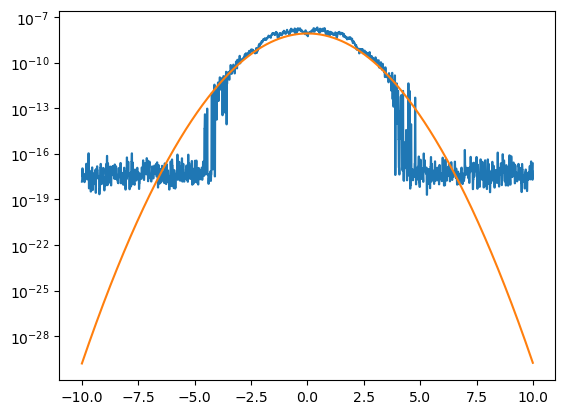

In [205]:
dx=0.01
xgrid=np.arange(-10,10,dx)
pofxgrid=np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)*dx

#for nbins in [10,50,100,200,500,1000]:
for nbins in [1000]:
    print('nbins ',nbins)
    ntoken = nbins+2 # Example: integers from 0 to 99
    bins=np.linspace(-10,10,nbins+1)
    delta=bins[1]-bins[0]

    ysamples=np.random.normal(size=(1,ndim-1))


    
    for ii in range(len(ysamples)):
        if ii%1000==0:
            print(ii)
        y=ysamples[ii]
    #    if ii%100==0:
    #        print(ii)
        xydata=np.array([np.concatenate(([[x],y])) for x in xgrid])
        problist=getprob_fromraw(xydata,model_sig_nbins[nbins],normed=True)
#        problist=np.prod(problist,axis=-1)
#        problist=problist/((20/nbins)**ndim)/factorial(ndim)
#
#        xydata_binned=np.digitize(xydata,bins)
#        xydata_binned_x=bins[xydata_binned-1]+delta/2
##        logproblist=np.log(problist)-ndim*np.log(20/nbins)-np.log(factorial(ndim))
#        npermlist=np.array([countperms(x)[1] for x in np.abs(xydata_binned_x)])
#        problist=problist*npermlist
#        logproblist=np.log(problist)-ndim*np.log(20/nbins)-np.log(factorial(ndim))
#        problist=problist #/(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))
        problist2=(np.exp(-np.sum(xydata**2,axis=-1)/2)/np.sqrt((np.pi*2)**ndim))

plt.plot(xgrid,problist)
plt.plot(xgrid,problist2)
plt.yscale('log')
#plt.ylim(1e-16,1e-4)

In [170]:
np.abs(xydata_binned_x)

array([[10.1,  1.3,  0.9,  0.7,  0.7,  0.7,  0.3,  0.3,  0.1,  0.1,  0.1]])

In [168]:
xydata_binned=preprocess_raw_to_binned([xydata[1000]])
xydata_binned_x=bins[xydata_binned-1]+delta/2
print(xydata_binned_x)

[[10.1 -1.3 -0.9  0.7  0.7 -0.7  0.3 -0.3 -0.1  0.1 -0.1]]


In [228]:
nbins=1000
ntoken = nbins+2 # Example: integers from 0 to 99
bins=np.linspace(-10,10,nbins+1)
delta=bins[1]-bins[0]
moredata=np.random.normal(size=(100000,10))
probtemp=getprob_fromraw(moredata[:10000],model_sig_nbins[nbins],normed=True)

In [186]:
moredata_binned=preprocess_raw_to_binned(moredata[:10000])

In [158]:
moredata_binned[0]

array([101,  38,  57,  44,  57,  55,  54,  48,  53,  49,  51])

In [159]:
preprocess_raw_to_binned([[ 0.02467923,  1.26546788, -0.40404878 ,  0.80009013, 0.56327307,
        0.72829231, -0.2401596 , -1.25200533,  1.26062087, -2.42112473]])

array([[101,  38,  57,  44,  57,  55,  54,  53,  48,  49,  51]])

In [156]:
np.digitize(moredata[0],bins)

array([51, 57, 53, 55, 48, 54, 49, 44, 57, 38])

In [149]:
bins[moredata_binned[0][1:]-1]+delta/2

array([-2.5,  1.3, -1.3,  1.3,  0.9,  0.7, -0.5,  0.5, -0.3,  0.1])

In [154]:
moredata_binned[0]

array([101,  38,  57,  44,  57,  55,  54,  48,  53,  49,  51])

In [152]:
bins_t=torch.tensor(bins).to(device)

x = torch.tensor(moredata_binned, dtype=torch.long)
dataset = TensorDataset(x)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=False)    

model_sig_nbins[nbins].eval()
problist=[]
with torch.no_grad():
    for inputs in dataloader:
        inputs=inputs[0]
        inputs2=torch.transpose(inputs,0,1).to(device)
        src_mask = model_sig_nbins[nbins].generate_square_subsequent_mask(inputs2.size(0)).to(device)
        
        nperms=np.ones(len(inputs))
        inputs_x=bins_t[(inputs.to(device))[:,1:]-1]+delta/2
        counts=batched_bincount(torch.bucketize(torch.abs(inputs_x),bins_t,right=True),1,len(bins_t)+2)
        nperms=np.prod(factorial(counts.detach().cpu().numpy()),axis=-1)
            


        outputs = model_sig_nbins[nbins](inputs2,src_mask)
        outputs=torch.transpose(outputs,0,1)
        outputs=nn.Softmax(dim=-1)(outputs)
        outputs=outputs.cpu().numpy()
        inputs=inputs.cpu().numpy()

        for prob,event,nperm in zip(outputs,inputs,nperms):
            problist.append(nperm*np.prod(prob[:-1][np.arange(ndim),event[1:]]))
        break
problist=np.array(problist)
problist=problist/(((20/nbins)**ndim)*factorial(ndim))


In [153]:
inputs_x[0]

tensor([-2.5000,  1.3000, -1.3000,  1.3000,  0.9000,  0.7000, -0.5000,  0.5000,
        -0.3000,  0.1000], device='cuda:0', dtype=torch.float64)

In [177]:
torch.floor(torch.abs(inputs_x[0]/delta))

tensor([12.,  6.,  6.,  6.,  4.,  3.,  2.,  2.,  1.,  0.], device='cuda:0',
       dtype=torch.float64)

In [224]:
np.mean(probtemp/np.exp(-0.5*np.sum(moredata[:10000]**2,axis=-1)-ndim*np.log(np.sqrt(2*np.pi))))

1.0626963615290002

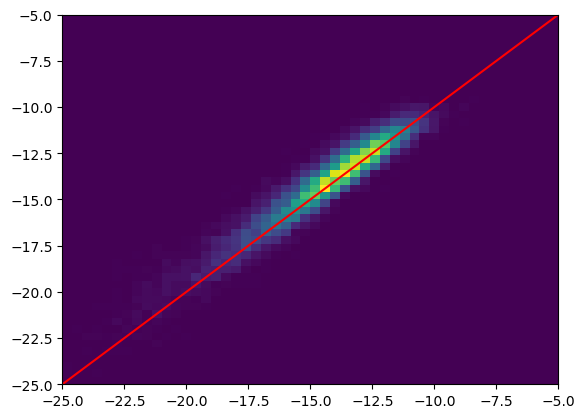

In [229]:
_=plt.hist2d(np.log(probtemp),\
           -0.5*np.sum(moredata[:10000]**2,axis=-1)-ndim*np.log(np.sqrt(2*np.pi)),bins=50,range=[[-25,-5],[-25,-5]])
plt.plot(np.linspace(-28,-5,2),np.linspace(-28,-5,2),color='r')


Text(0, 0.5, '|f_k|')

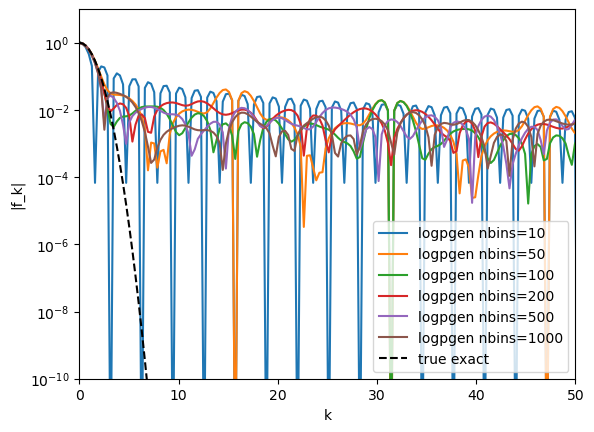

In [514]:
colors = plt.cm.viridis(np.linspace(0,1,5))

#plt.plot(klist,np.abs(ftlist_true_hybrid),label='true logp, hybrid euler/mc')
klist=np.arange(0,200,2*np.pi/20)  #+np.pi/20
freqlist=np.array([[np.cos(xx*k) for xx in xgrid] for k in klist])    
for nbins in [10,50,100,200,500,1000]:
#for nbins in [10]:
    plt.plot(klist,np.abs(freqlist@ftxlist_sig_x2000_nbins[nbins]),label='logpgen nbins='+str(nbins))
plt.plot(klist,np.abs(np.exp(-klist**2/2)),label='true exact',color='black',linestyle='dashed')
plt.yscale('log')
plt.ylim(1e-10,10)
plt.xlim(0,50)
plt.legend()
plt.xlabel('k')
plt.ylabel('|f_k|')

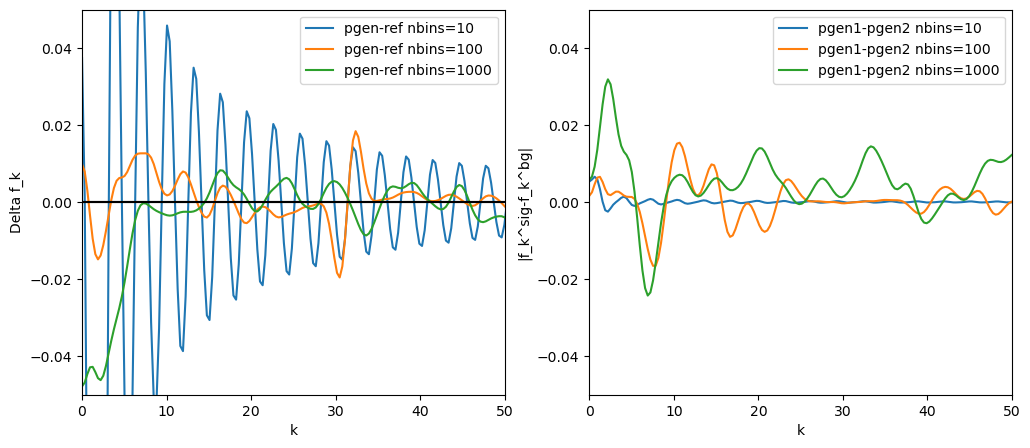

In [531]:
colors = plt.cm.viridis(np.linspace(0,1,5))

#plt.plot(klist,np.abs(ftlist_true_hybrid),label='true logp, hybrid euler/mc')
klist=np.arange(0,200,2*np.pi/20)  #+np.pi/20
freqlist=np.array([[np.cos(xx*k) for xx in xgrid] for k in klist])    


fig,ax=plt.subplots(1,2,figsize=(12,5))

for nbins in [10,100,1000]:
#for nbins in [10]:
    ax[0].plot(klist,freqlist@ftxlist_sig_x2000_nbins[nbins]-np.exp(-klist**2/2),label='pgen-ref nbins='+str(nbins))
#plt.plot(klist,np.abs(np.exp(-klist**2/2)),label='true exact',color='black',linestyle='dashed')
#plt.yscale('log')
ax[0].set_ylim(-0.05,0.05)
ax[0].set_xlim(0,50)
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('Delta f_k')
ax[0].axhline(0,color='black')


for nbins in [10,100,1000]:
#for nbins in [10]:
    ax[1].plot(klist,freqlist@ftxlist_bg_x2000_nbins[nbins]-freqlist@ftxlist_sig_x2000_nbins[nbins],label='pgen1-pgen2 nbins='+str(nbins))
#plt.plot(klist,np.abs(np.exp(-klist**2/2)),label='true exact',color='black',linestyle='dashed')
#plt.yscale('log')
ax[1].set_ylim(-.05,.05)
ax[1].set_xlim(0,50)
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('|f_k^sig-f_k^bg|')
ax[0].axhline(0,color='black')


(0.0, 100.0)

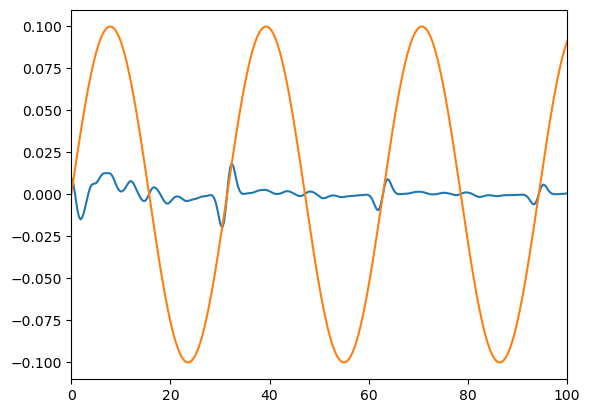

In [538]:
for nbins in [100]:
#for nbins in [10]:
    plt.plot(klist,freqlist@ftxlist_sig_x2000_nbins[nbins]-np.exp(-klist**2/2),label='pgen-ref nbins='+str(nbins))
plt.plot(klist,0.1*np.sin(klist*20/nbins))
plt.xlim(0,100)

0.00012919268415515333
0.001257237105613389
0.0007681930650630984
0.0014261598773057922
0.0034380506352778488
0.005564132970676772


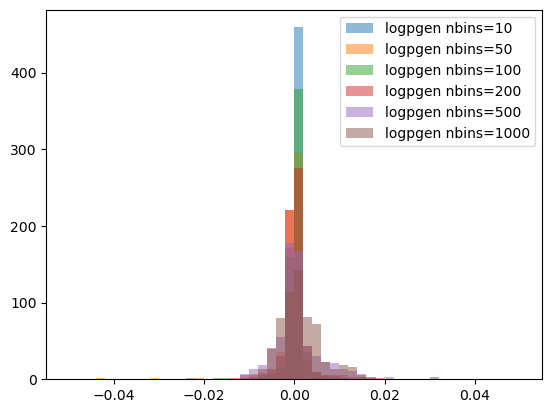

In [529]:
from scipy.stats import iqr

for nbins in [10,50,100,200,500,1000]:
#for nbins in [10]:
    print(iqr(freqlist@ftxlist_bg_x2000_nbins[nbins]-freqlist@ftxlist_sig_x2000_nbins[nbins]))
    plt.hist(freqlist@ftxlist_bg_x2000_nbins[nbins]-freqlist@ftxlist_sig_x2000_nbins[nbins],label='logpgen nbins='+str(nbins),range=[-0.05,0.05],bins=50,alpha=0.5)
plt.legend()

Text(0, 0.5, '|f_k|')

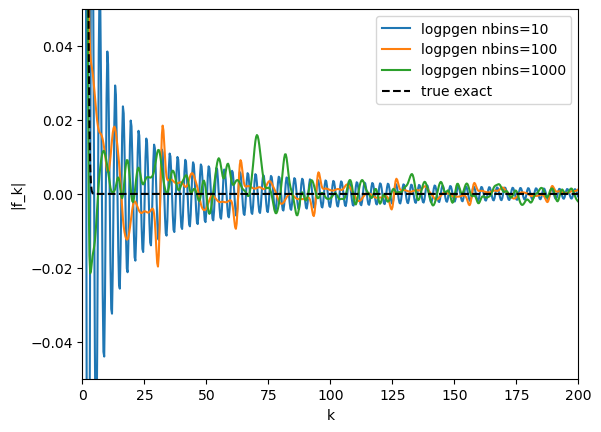

In [240]:
colors = plt.cm.viridis(np.linspace(0,1,5))

#plt.plot(klist,np.abs(ftlist_true_hybrid),label='true logp, hybrid euler/mc')
klist=np.arange(0,200,2*np.pi/20)  #+np.pi/20
freqlist=np.array([[np.cos(xx*k) for xx in xgrid] for k in klist])    
for nbins in [10,100,1000]:
#for nbins in [10]:
    plt.plot(klist,freqlist@ftxlist_bg_x2000_nbins[nbins],label='logpgen nbins='+str(nbins))
plt.plot(klist,np.exp(-klist**2/2),label='true exact',color='black',linestyle='dashed')
#plt.yscale('log')
plt.ylim(-0.05,0.05)
plt.xlim(0,200)
plt.legend()
plt.xlabel('k')
plt.ylabel('|f_k|')

Text(0, 0.5, '|f_k^sig-f_k^bg|')

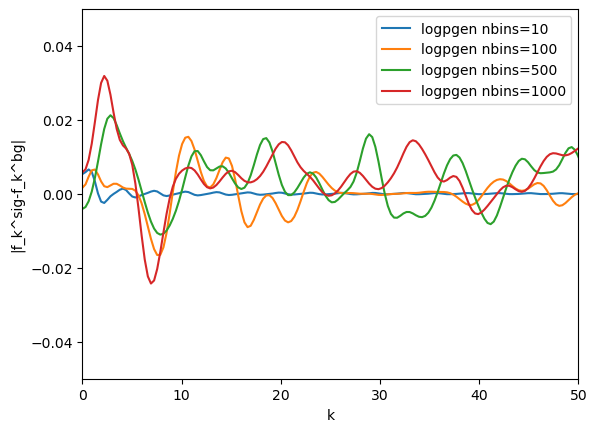

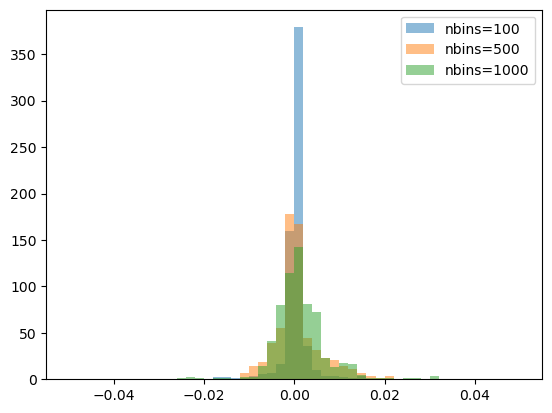

In [272]:
plt.hist(freqlist@ftxlist_bg_x2000_nbins[100]-freqlist@ftxlist_sig_x2000_nbins[100],range=[-0.05,0.05],bins=50,alpha=0.5,label='nbins=100')
plt.hist(freqlist@ftxlist_bg_x2000_nbins[500]-freqlist@ftxlist_sig_x2000_nbins[500],range=[-0.05,0.05],bins=50,alpha=0.5,label='nbins=500')
plt.hist(freqlist@ftxlist_bg_x2000_nbins[1000]-freqlist@ftxlist_sig_x2000_nbins[1000],range=[-0.05,0.05],bins=50,alpha=0.5,label='nbins=1000')
plt.legend()

In [24]:
dx=0.01
xgrid=np.arange(-10,10,dx)
pofxgrid=np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)*dx

#ftxlist_bg_x2000_nbins={}
for nbins in [10]:
    print('nbins ',nbins)
    ntoken = nbins+2 # Example: integers from 0 to 99
    bins=np.linspace(-10,10,nbins+1)
    delta=bins[1]-bins[0]

    ysamples=np.random.normal(size=(5000,ndim-1))

    ftxlist_bg_x2000_TEMP=np.zeros(len(xgrid))
    for ii in range(1):
        if ii%1000==0:
            print(ii)
        y=ysamples[ii]
    #    if ii%100==0:
    #        print(ii)
        xydata=np.array([np.concatenate(([[x],y])) for x in xgrid])
        problist=getprob_fromraw(xydata,model_bg_nbins[nbins])
        problist=np.prod(problist,axis=-1)
        logproblist=np.log(problist)-ndim*np.log(20/nbins)-np.log(factorial(ndim))
        ftxlist_bg_x2000_TEMP+=logproblist*pofxgrid
    ftxlist_bg_x2000_TEMP=ftxlist_bg_x2000_TEMP/len(ysamples)

    

nbins  10
0


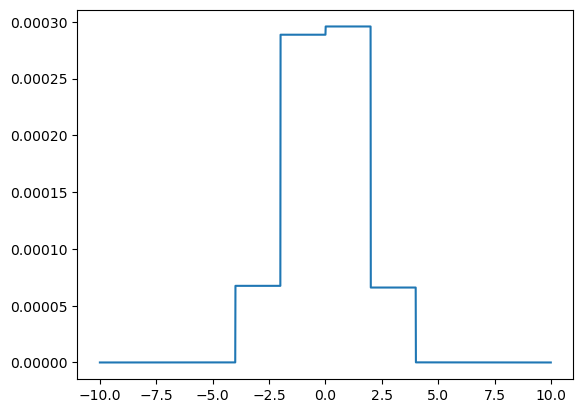

In [28]:
plt.plot(xgrid,problist)

In [20]:
testdata_x=bins[testdata[testlabels==1][:,1:]-1]+delta/2
print(testdata_x.shape)

(49853, 10)


In [28]:
moredata_sorted.shape

(1000000, 10)

In [26]:
gendata.shape

(256000, 11)

0.6473246070556642


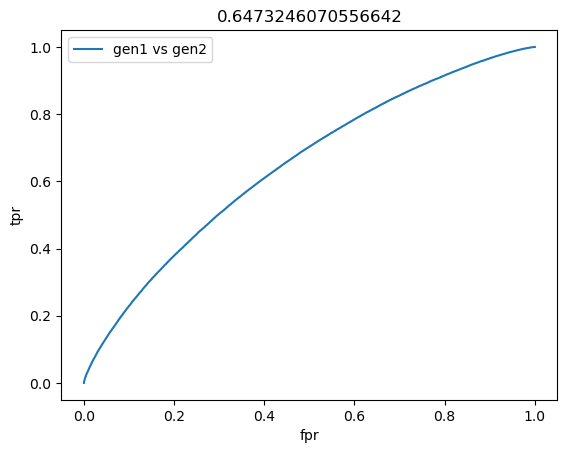

In [29]:
plt.plot(fpr,tpr,label='gen1 vs gen2')
plt.title(auc)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

In [ ]:
# smearing study

In [ ]:
def getprobsmear(data,model,sigma):
    data_x=bins[data[:,1:]-1]+delta/2
    data_x_100=np.array([data_x for ii in range(100)])
    eps_smearing=sigma*np.random.normal(size=data_x_100.shape)
    data_x_smeared=data_x_100+eps_smearing
    
    data_smeared_sorted=[]
    for x in data_x_smeared:
        binneddata_smeared=np.digitize(x,bins)
        binneddata_smeared_x=bins[binneddata_smeared-1]+delta/2
    
        binneddata_smeared_sorted=binneddata_smeared[np.arange(len(binneddata_smeared)).reshape((-1,1)),np.argsort(np.abs(binneddata_smeared_x),axis=-1)[:,::-1]]
    
        binneddata_smeared_sorted=add_start_token(binneddata_smeared_sorted)
        data_smeared_sorted.append(binneddata_smeared_sorted)
    data_smeared_sorted=np.array(data_smeared_sorted)
    data_smeared_sorted=data_smeared_sorted.reshape((-1,11))
    
    print(data_smeared_sorted.shape)
    problist_smeared=getprob(data_smeared_sorted,model)

    
    problist_smeared=problist_smeared.reshape((100,-1,10))        


    problist_smeared2=np.mean(np.prod(problist_smeared,axis=-1),axis=0)

    return problist_smeared2

def getprobsmear_fromraw(data_raw,model,sigma):

    data_binned=preprocess_raw_to_binned(data_raw)

    problist=getprobsmear(data_binned,model,sigma)
    
    return problist